<a href="https://colab.research.google.com/github/dho619/TCC_Pos_IA/blob/main/Algoritmo_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [11]:
#Para documentação de passo a passo e justificativa dessa função, pode encontrá-la no arquivo TratamentoDosDados.ipynb
def TratarDadosBaseWalmart(df):
  df.Date=pd.to_datetime(df.Date, format='%d-%m-%Y')
  df['Day'] = df.Date.dt.day
  df['Month'] = df.Date.dt.month
  df['Year'] = df.Date.dt.year
  df.drop(['Date'], axis=1, inplace=True)

  df.drop_duplicates(inplace=True)

  ignoreFeatures = ['Weekly_Sales', 'Day']
  maximumToBeCategorical = 45
  features = [i for i in df.columns if i not in ignoreFeatures]
  uniqueValuesForFeature = df[features].nunique().sort_values()
  categoricalFeature = [];
  valuesFeature = [];
  for i in range(df[features].shape[1]):
      if uniqueValuesForFeature.values[i]<=maximumToBeCategorical:
          categoricalFeature.append(uniqueValuesForFeature.index[i])
      else:
          valuesFeature.append(uniqueValuesForFeature.index[i])
  for i in categoricalFeature:
    if df[i].nunique()==2:
        df[i]=pd.get_dummies(df[i], drop_first=True, prefix=str(i))
    if (df[i].nunique()>2):
        df = pd.concat([df.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df[i], prefix=str(i)))],axis=1)
    
  return df


In [12]:
#Para documentação de passo a passo e justificativa dessa função, pode encontrá-la no arquivo PreparaçãoDeDados.ipynb

def NormalizarValores(df, columns):
  for column in columns:
    df[column] = df[column]/df[column].max()

def PertenceAMesmaLoja(df, num1, num2):
  if num1 < 0 or num2 < 0: return False
  for i in range(1, 46):
    if df["Store_" + str(i)][num1] != df["Store_" + str(i)][num2]: return False
  return True

def PreparaDados(df, formatoDados):
  target = "Weekly_Sales"

  df["SalesOneWeekAgo"] = np.zeros(len(df[target]))
  df["SalesTwoWeeksAgo"] = np.zeros(len(df[target]))
  df["SalesThreeWeeksAgo"] = np.zeros(len(df[target]))

  for i, sales in enumerate(df[target]):
    df["SalesOneWeekAgo"][i] = df[target][i-1] if PertenceAMesmaLoja(df, i, i-1) else df[target][i]
    df["SalesTwoWeeksAgo"][i] = df[target][i-2] if PertenceAMesmaLoja(df, i, i-2) else df[target][i]
    df["SalesThreeWeeksAgo"][i] = df[target][i-3] if PertenceAMesmaLoja(df, i, i-3) else df[target][i]

  #Normalizando valores
  columns = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]
  NormalizarValores(df, columns)

  filtro_treino = df["Year_2012"] == 0
  filtro_teste = df["Year_2012"] == 1

  train = df.where(filtro_treino).dropna()
  test =  df.where(filtro_teste).dropna()

  y_train = train[target].array
  X_train = train.drop([target, "Year_2010", "Year_2011", "Year_2012"],axis=1)
  
  y_test = test[target].array
  X_test = test.drop([target, "Year_2010", "Year_2011", "Year_2012"],axis=1)

  X_train.reset_index(drop=True,inplace=True)

  return X_train.astype(formatoDados), X_test.astype(formatoDados), y_train.astype(formatoDados), y_test.astype(formatoDados)

In [13]:
df = pd.read_csv('./Walmart.csv')
df = TratarDadosBaseWalmart(df)

X_train, X_test, y_train, y_test = PreparaDados(df, np.float32)

print('Base original  ---> ',df.shape,df.shape,'\nBase de Treino  ---> ',X_train.shape,y_train.shape,'\nBase de teste   ---> ', X_test.shape,'', y_test.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Base original  --->  (6435, 70) (6435, 70) 
Base de Treino  --->  (4500, 66) (4500,) 
Base de teste   --->  (1935, 66)  (1935,)


In [14]:
mlr = LinearRegression()
mlr.fit(X_train, y_train)
mlr.score(X_train, y_train)
predictions = mlr.predict(X_test)

In [15]:
r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), np.sqrt(mean_squared_error(y_test, predictions))

(0.9592662258694408, 72461.21, 108282.68)

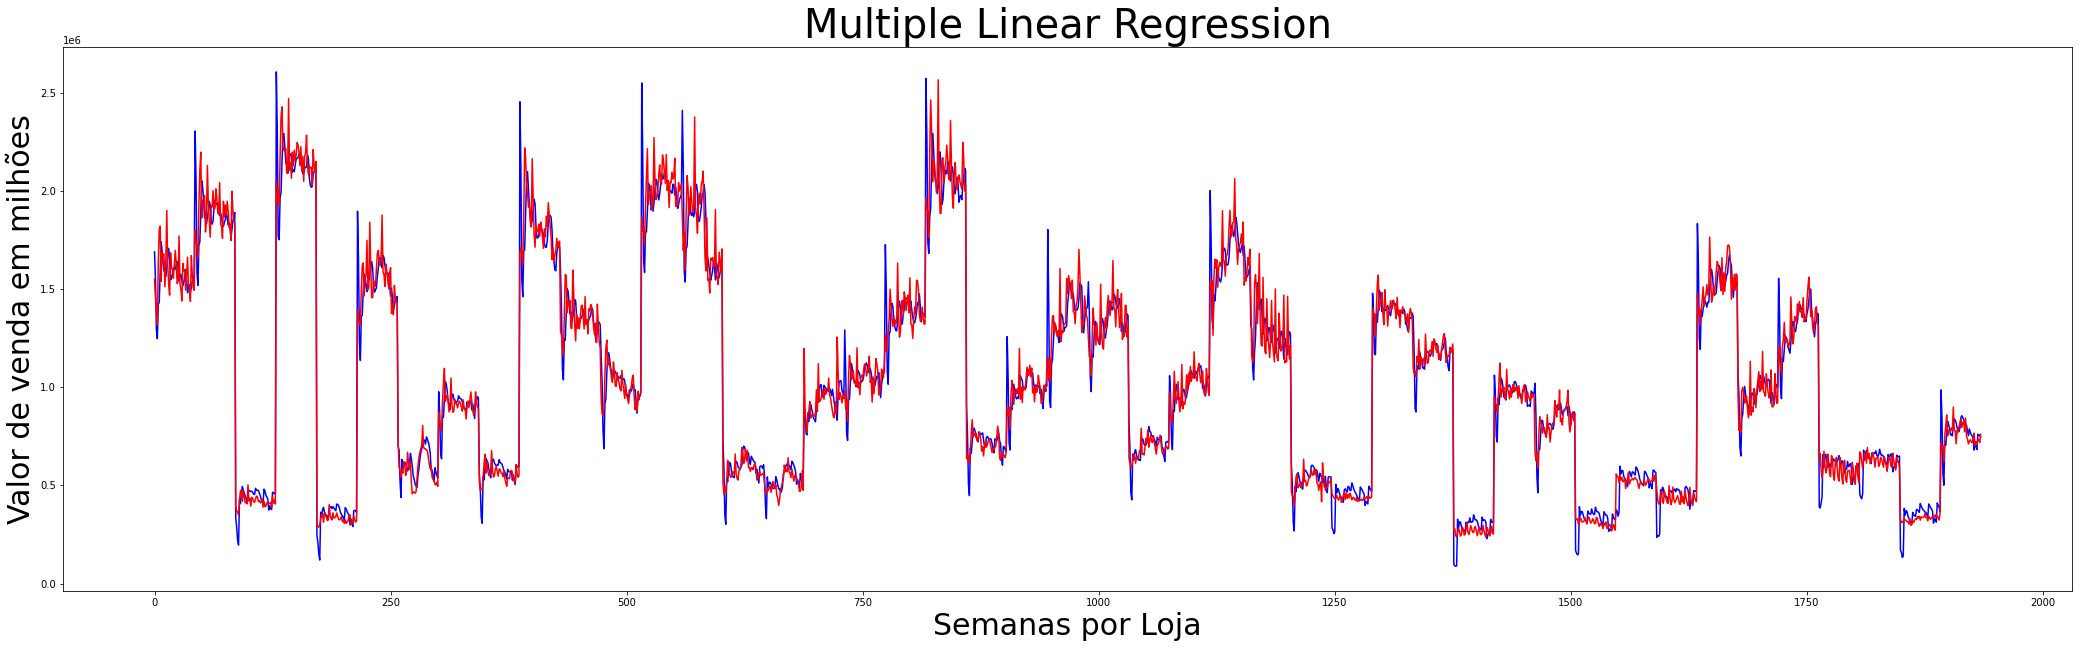

In [16]:
plt.figure(figsize = (36, 10))
plt.plot(range(len(predictions)), predictions, 'b')
plt.plot(range(len(predictions)), y_test, 'r')
plt.title("Multiple Linear Regression", fontsize=40)
plt.xlabel("Semanas por Loja", fontsize=30)
plt.ylabel("Valor de venda em milhões", fontsize=30)

plt.show()

In [17]:
for i, feature in enumerate(mlr.feature_names_in_):
  print("Feature {}: {}".format(feature, mlr.coef_[i]))


Feature Holiday_Flag: -28445.6171875
Feature Temperature: 16838.3125
Feature Fuel_Price: 3724.02783203125
Feature CPI: -2375.874267578125
Feature Unemployment: -5306.8291015625
Feature Day: -1361.80859375
Feature Month_1: -188235.125
Feature Month_2: 27509.50390625
Feature Month_3: -20677.7578125
Feature Month_4: 8341.078125
Feature Month_5: 11342.296875
Feature Month_6: 18189.767578125
Feature Month_7: -18968.7421875
Feature Month_8: 23234.703125
Feature Month_9: -41906.16015625
Feature Month_10: 20491.240234375
Feature Month_11: 128708.5078125
Feature Month_12: 27221.9375
Feature Store_1: 244.869140625
Feature Store_2: 388.9609375
Feature Store_3: -2446.470703125
Feature Store_4: -1843.4609375
Feature Store_5: -1947.83203125
Feature Store_6: -1670.318359375
Feature Store_7: 4267.35302734375
Feature Store_8: -555.896484375
Feature Store_9: -477.2275390625
Feature Store_10: -648.7432861328125
Feature Store_11: -2404.56787109375
Feature Store_12: -1549.6259765625
Feature Store_13: -786.

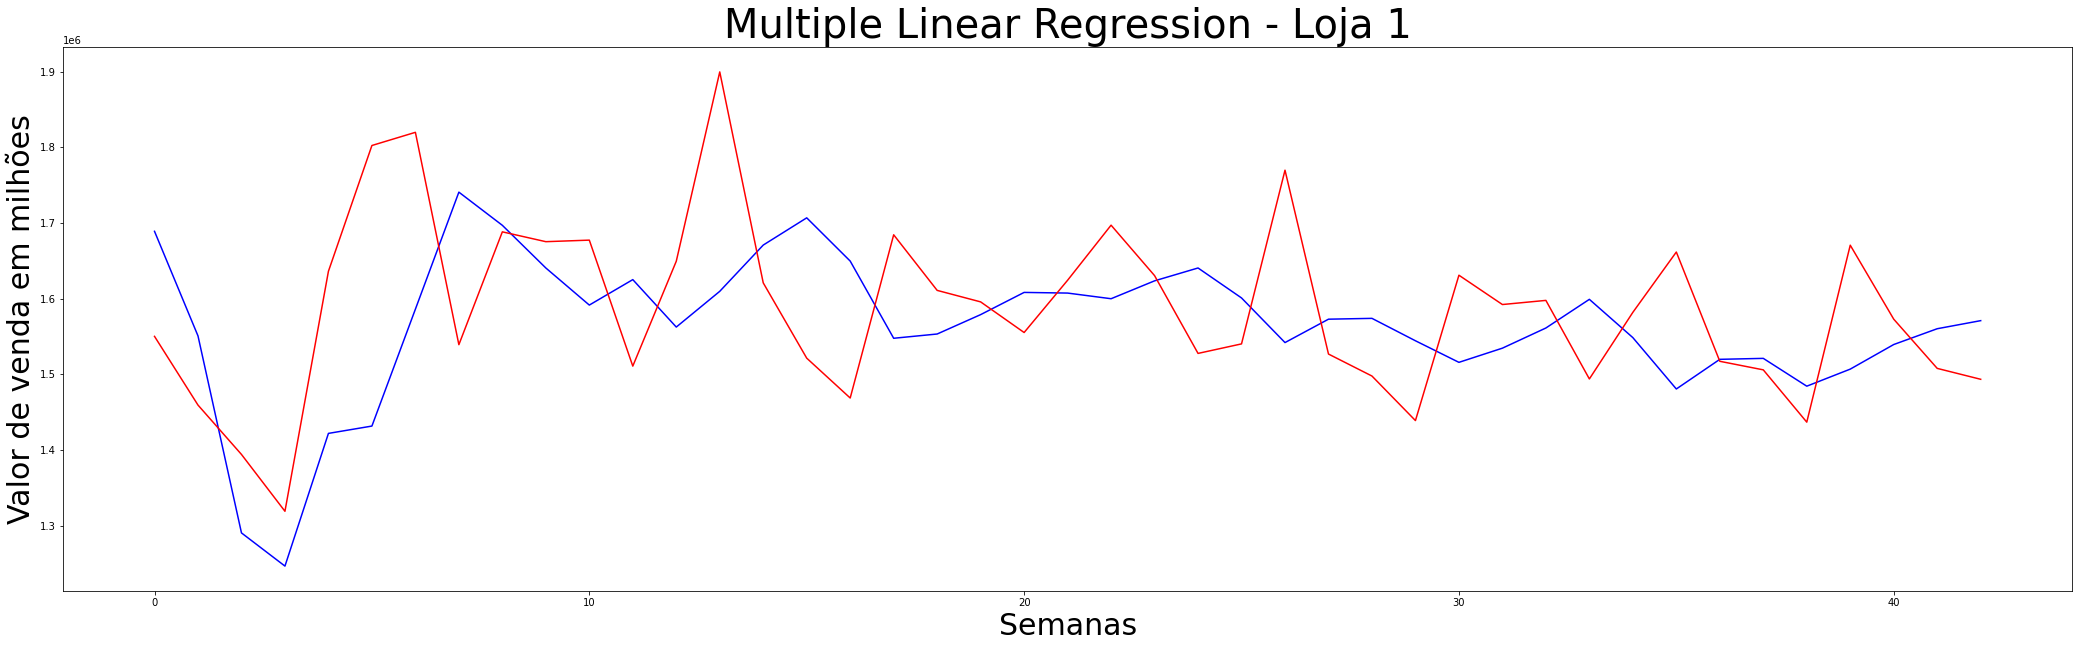

**************************************************
Resultados Loja 2:
-1.0241181509245392 109952.65 152711.94


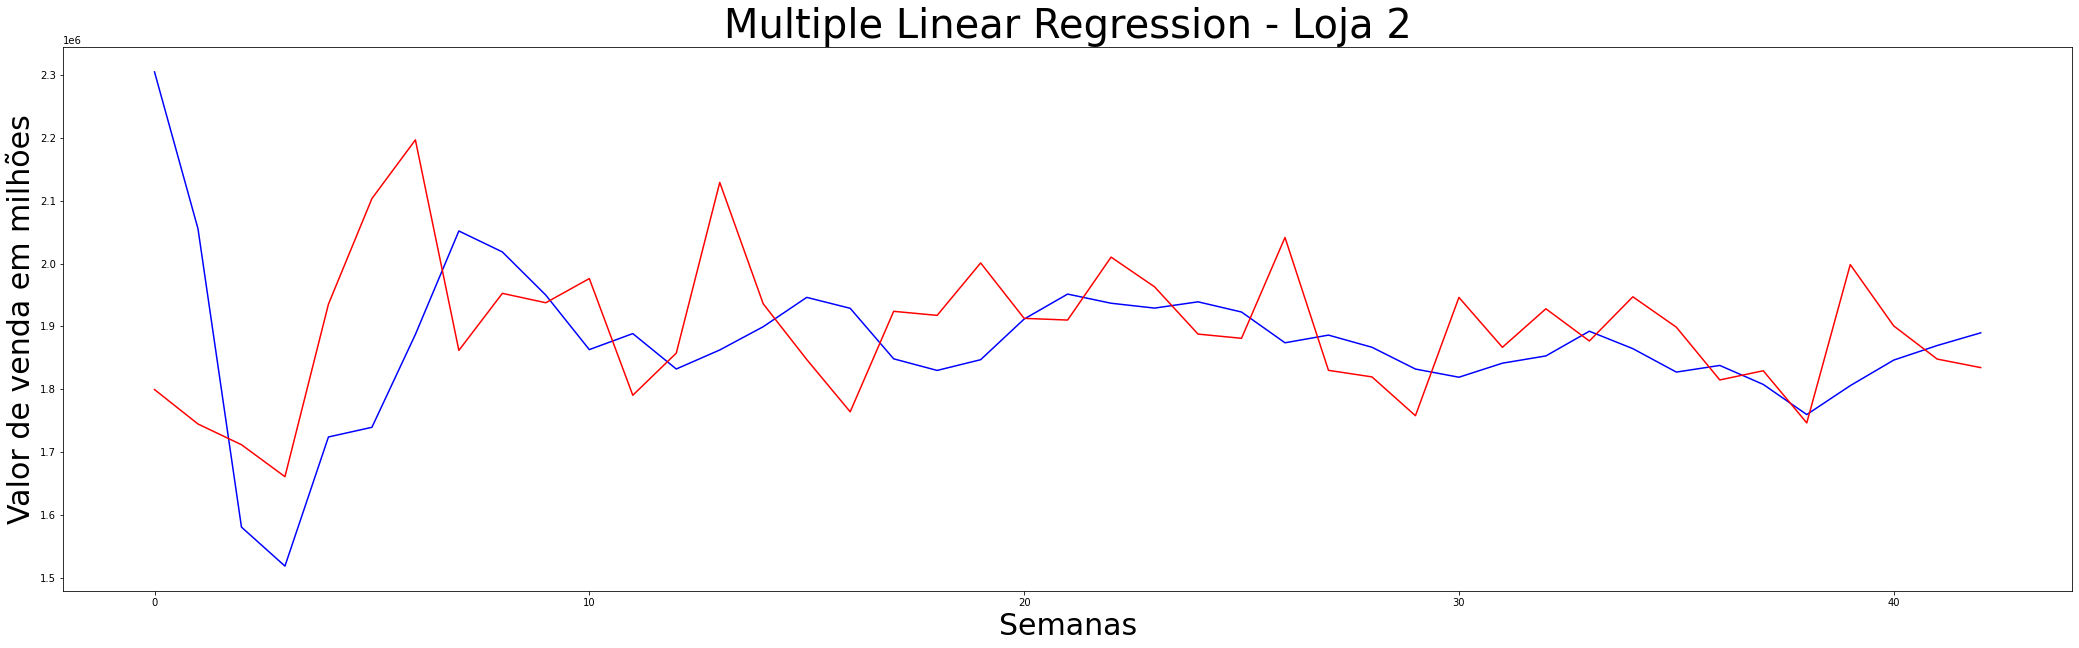

**************************************************
Resultados Loja 3:
-2.400797744388329 42347.402 52645.27


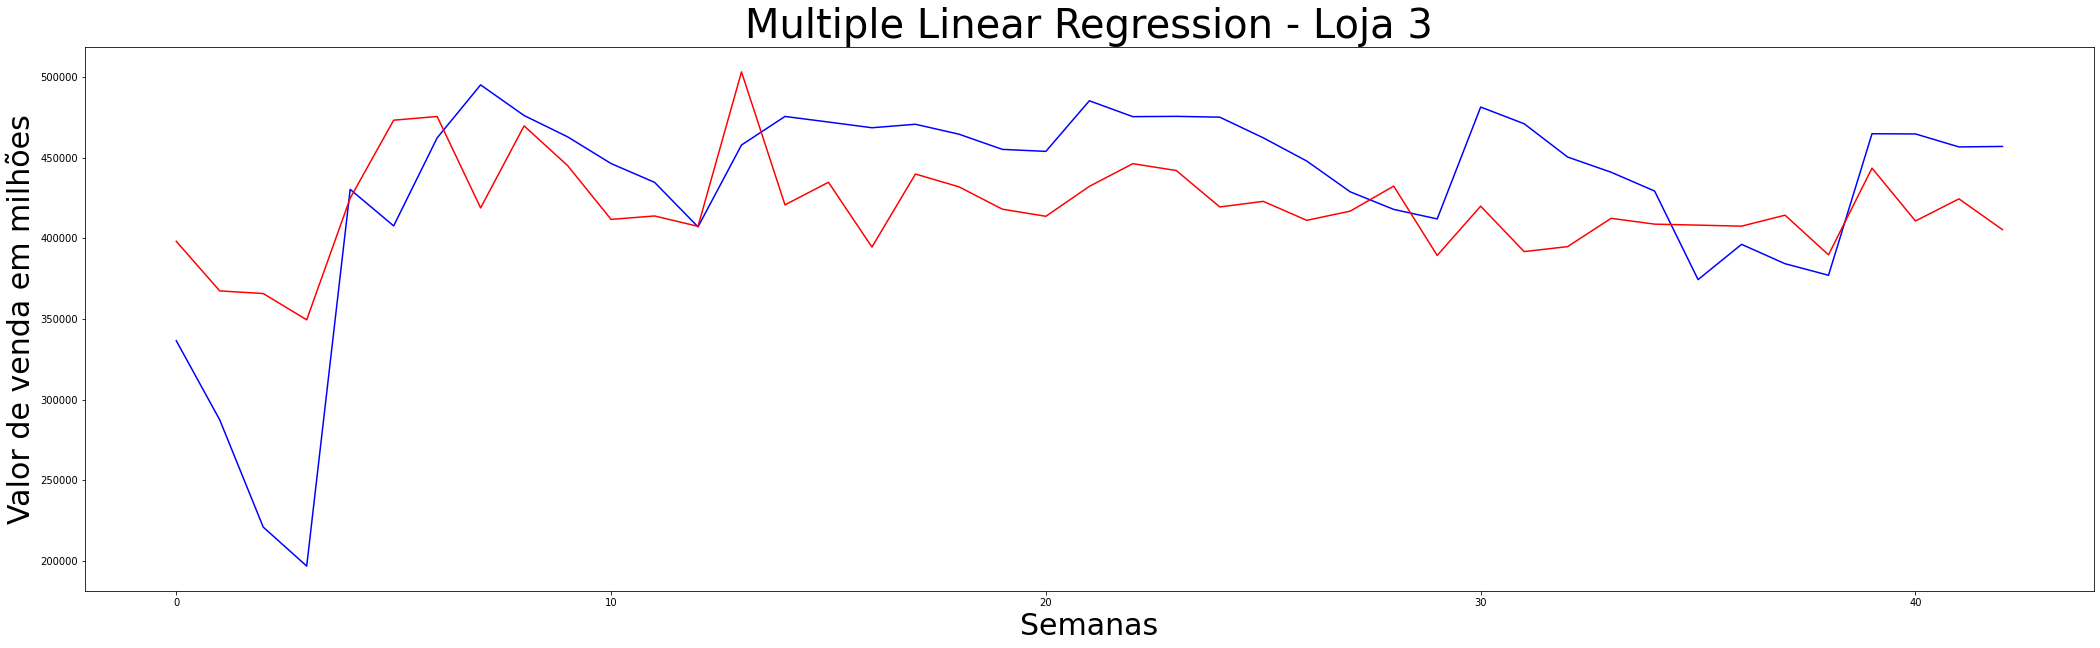

**************************************************
Resultados Loja 4:
-1.3488107798367914 109882.85 161776.7


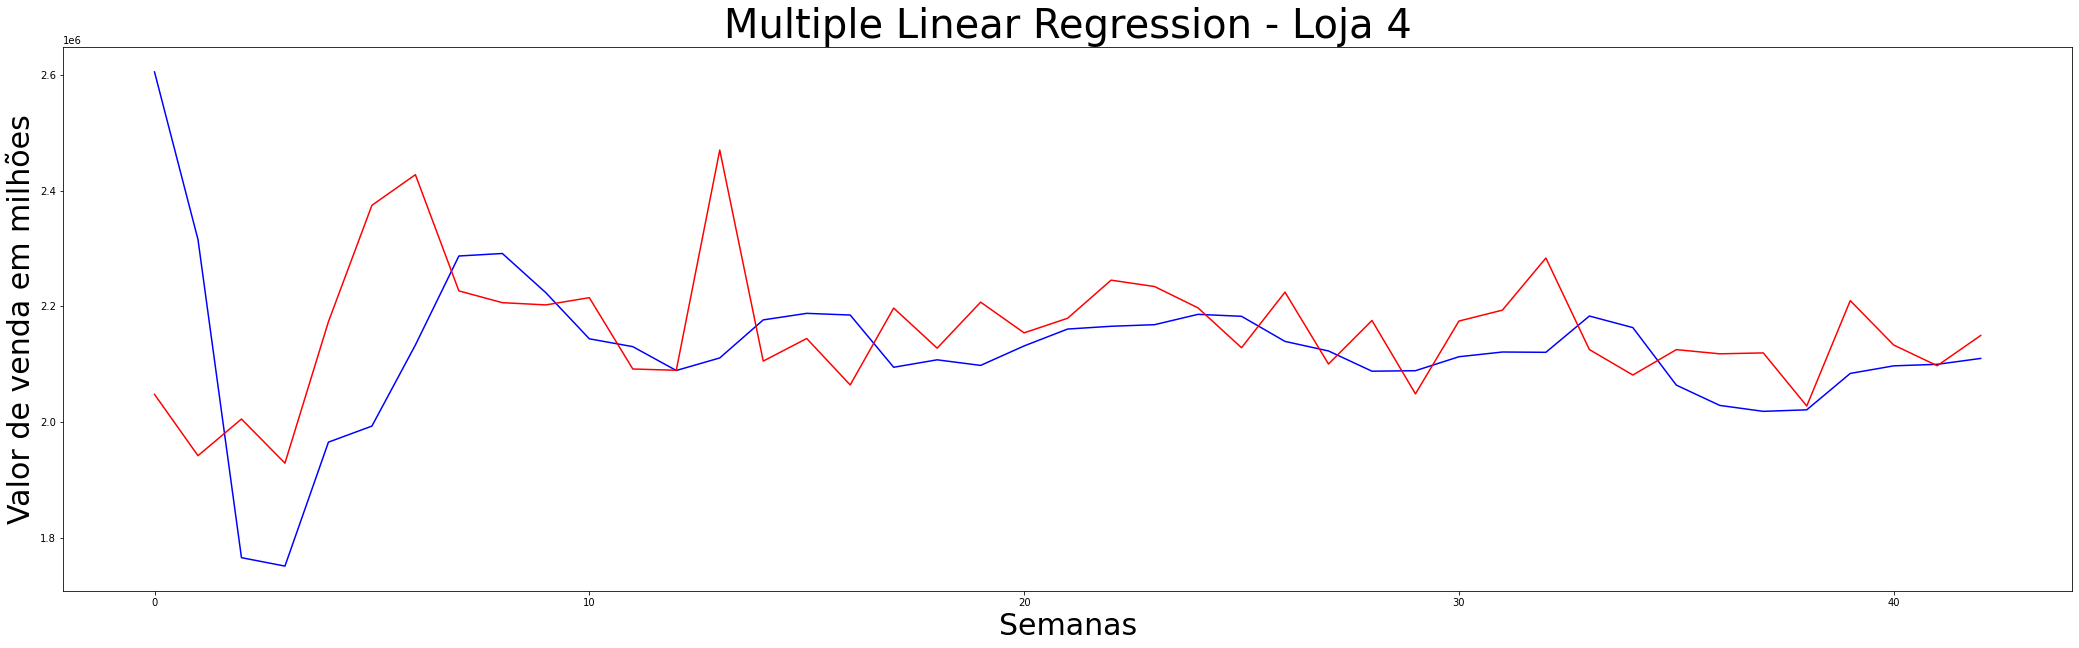

**************************************************
Resultados Loja 5:
-5.182817509362952 42586.312 54166.57


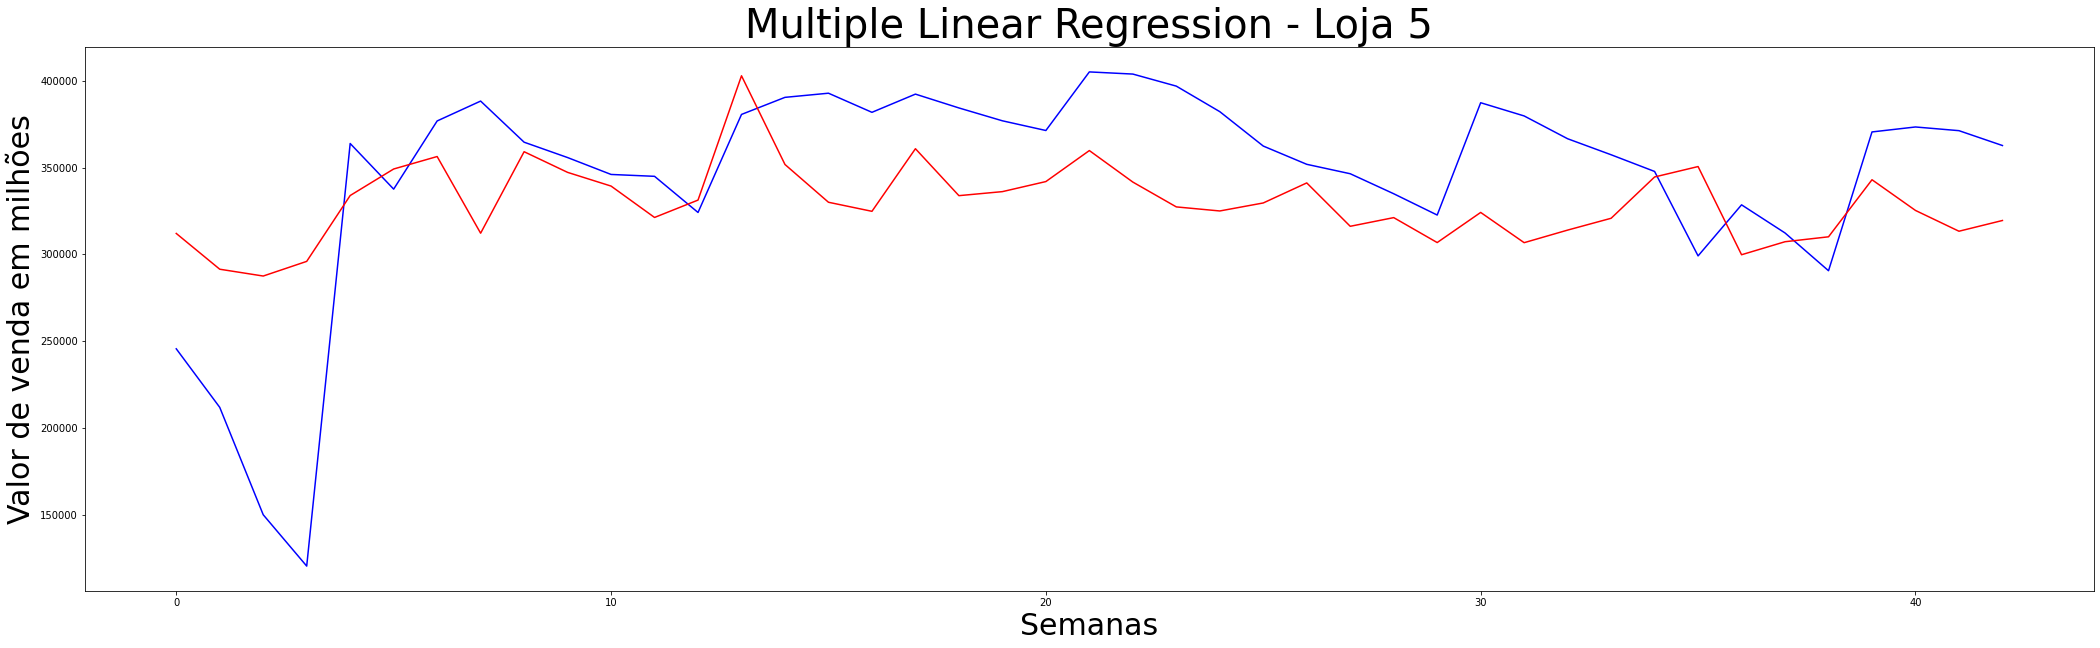

**************************************************
Resultados Loja 6:
-0.3987433576467212 104286.734 145044.02


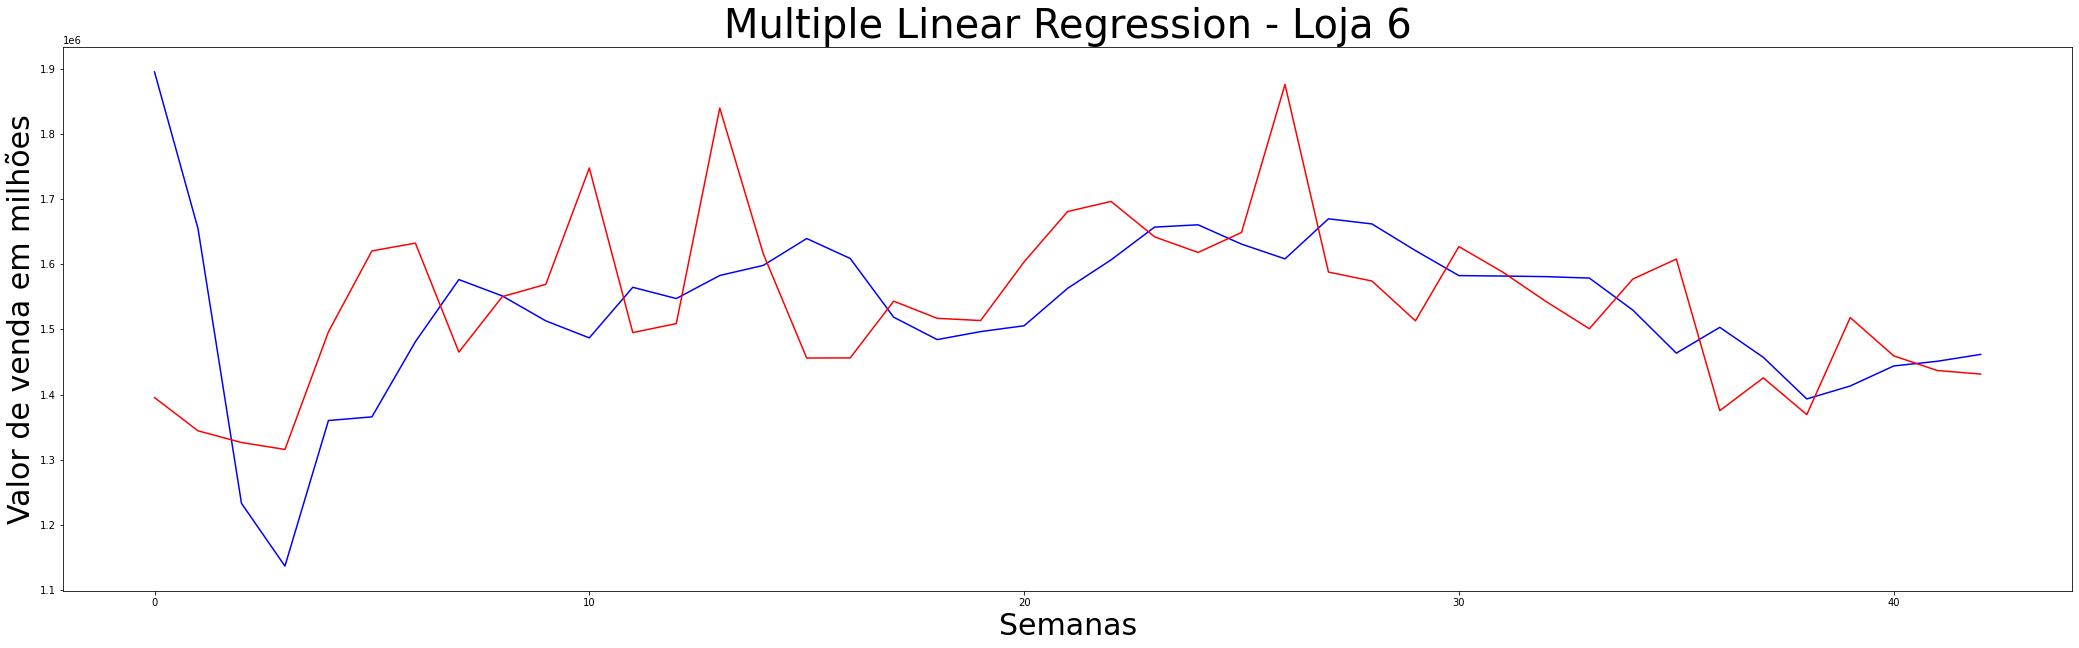

**************************************************
Resultados Loja 7:
0.4411788025199129 51707.39 60595.258


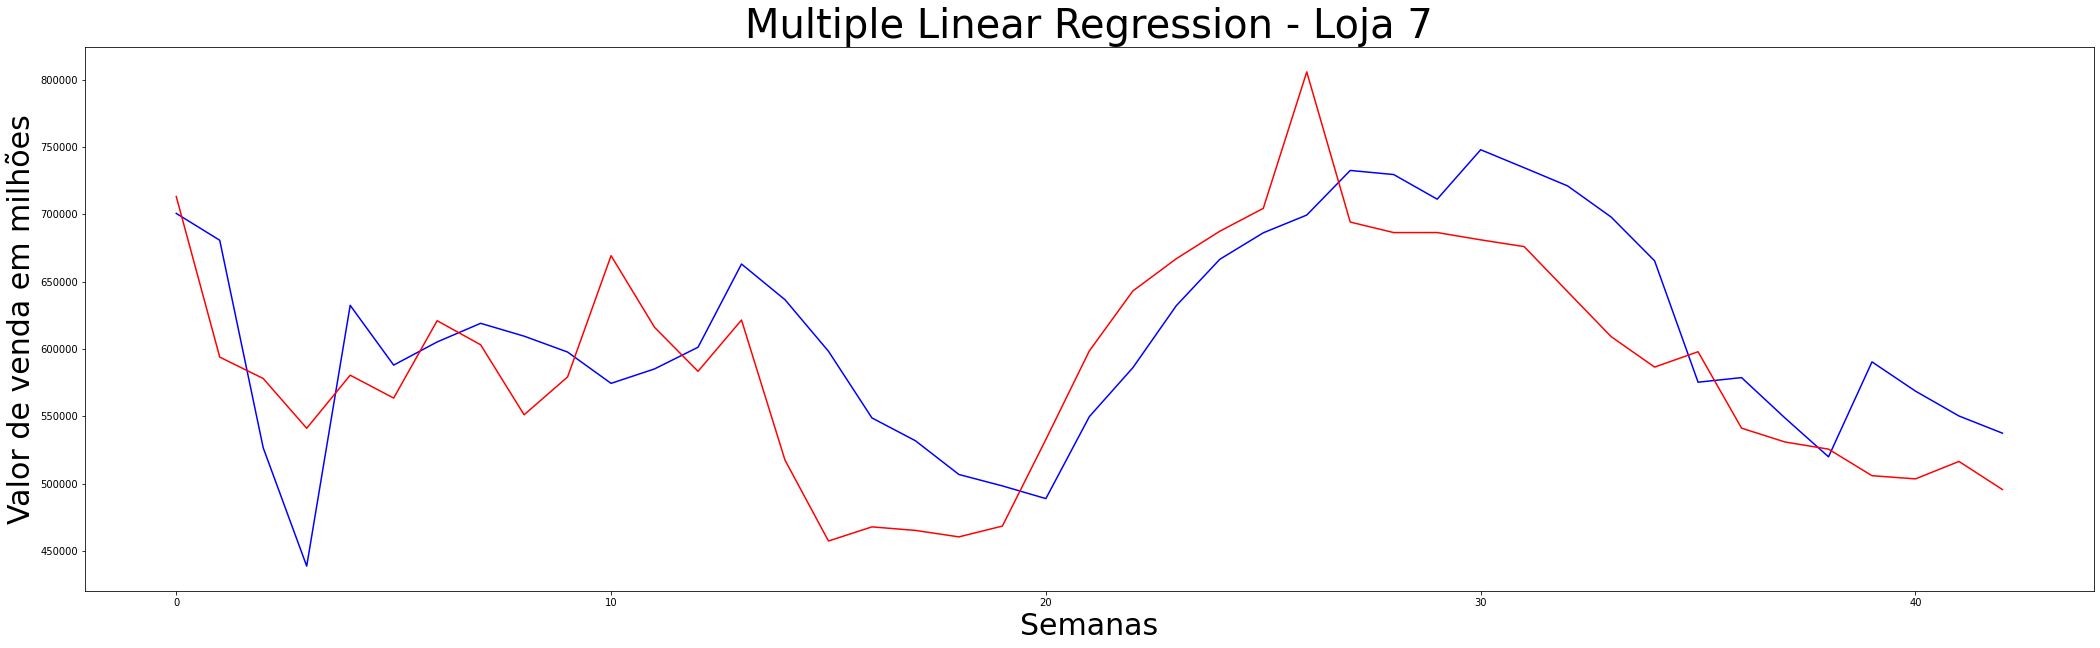

**************************************************
Resultados Loja 8:
-0.42828890803052033 50959.43 67160.11


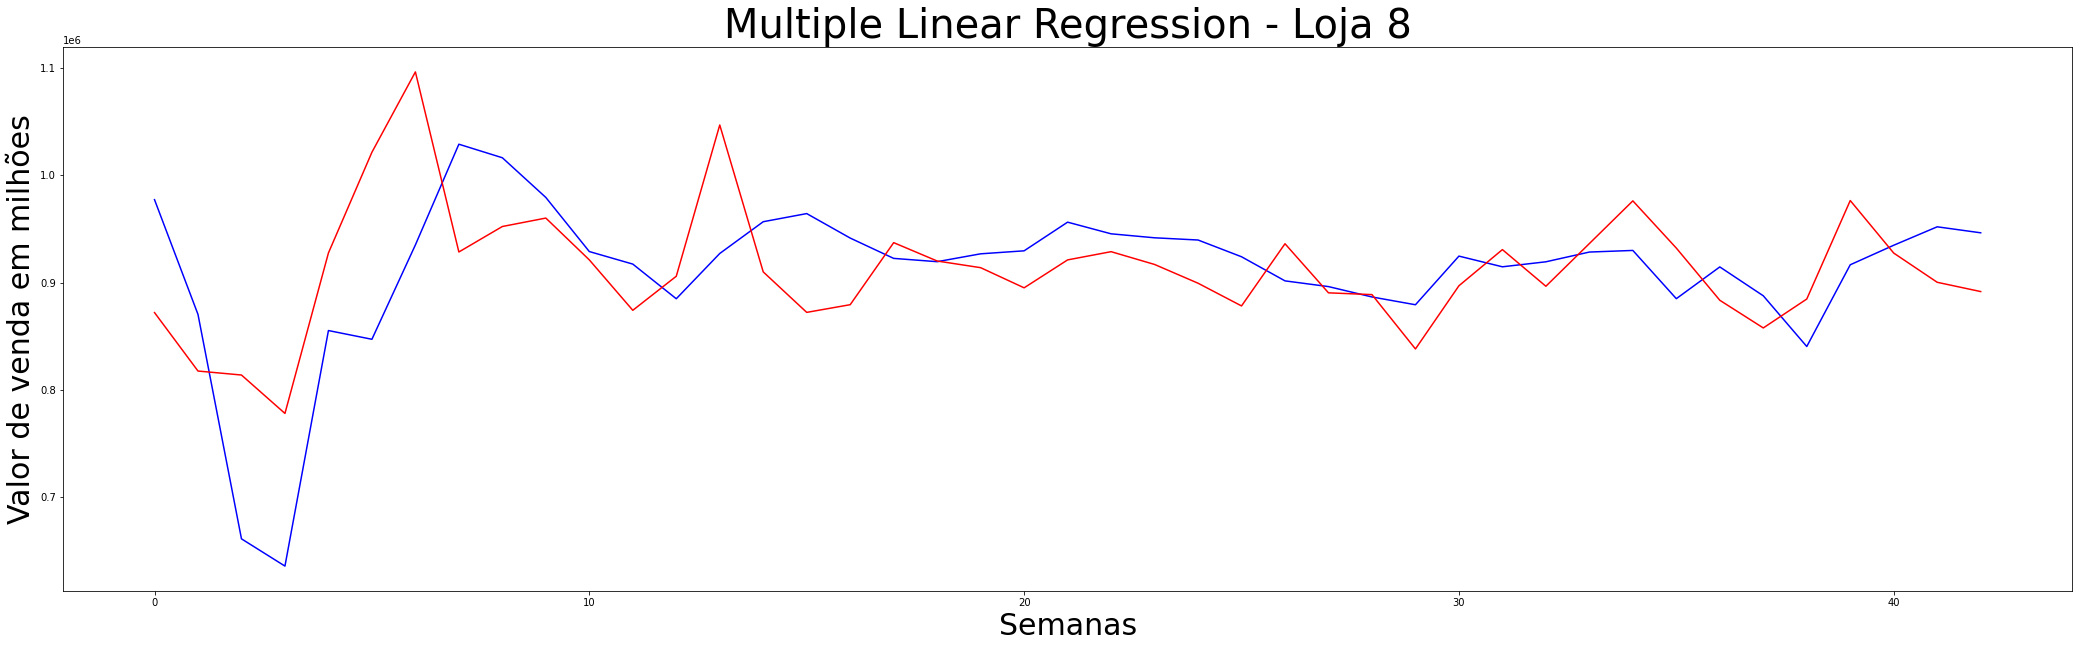

**************************************************
Resultados Loja 9:
-0.7933018363098108 42848.934 54587.594


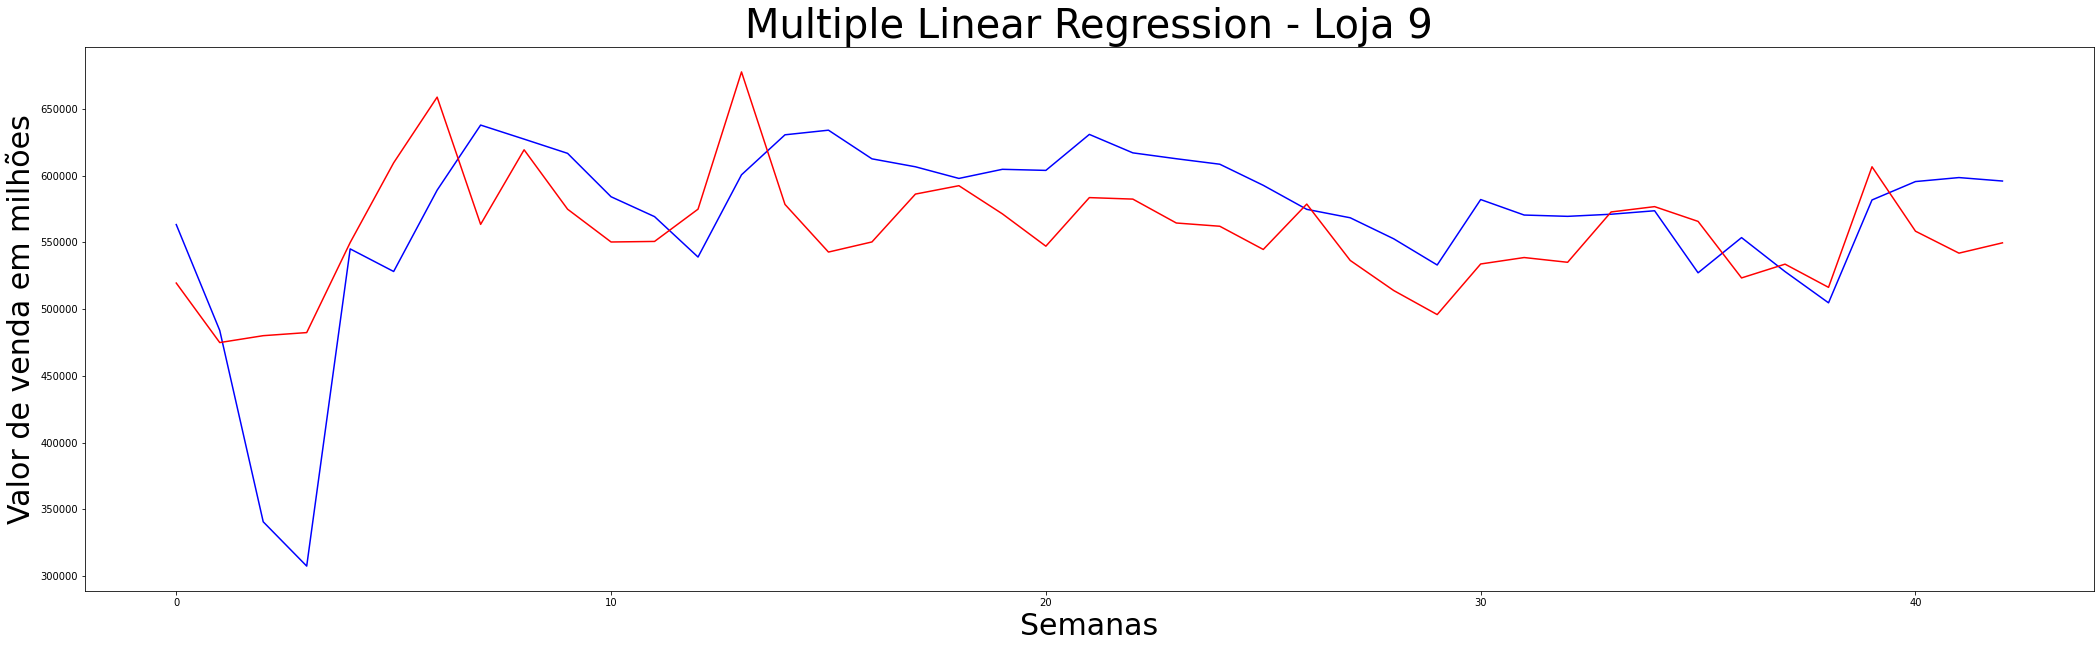

**************************************************
Resultados Loja 10:
-0.8685180639768981 114963.42 187729.27


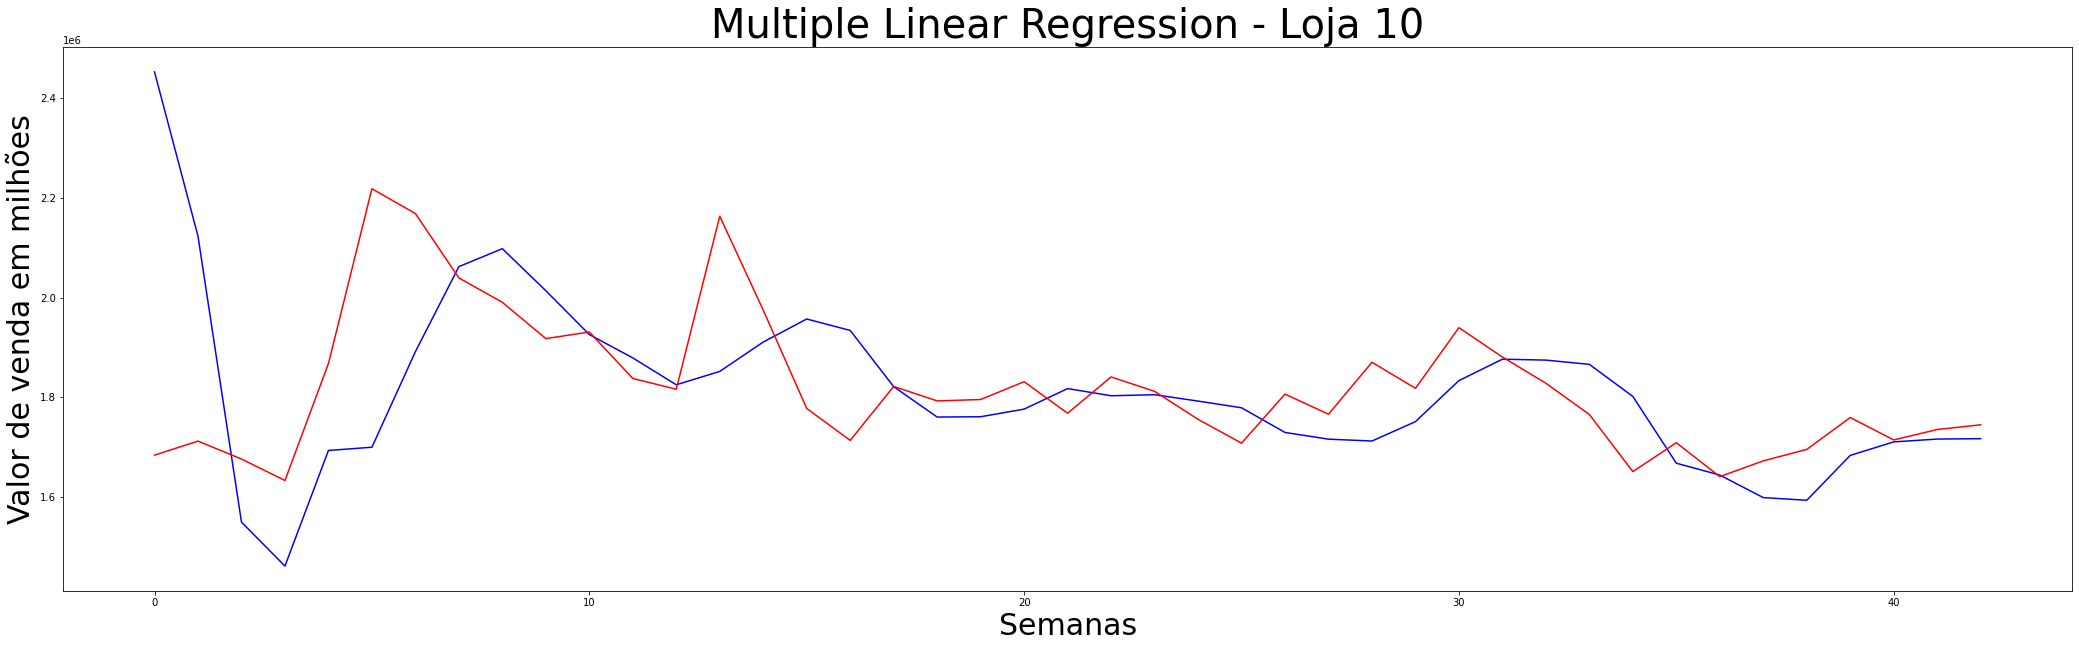

**************************************************
Resultados Loja 11:
-0.39011997050504177 84248.09 113578.63


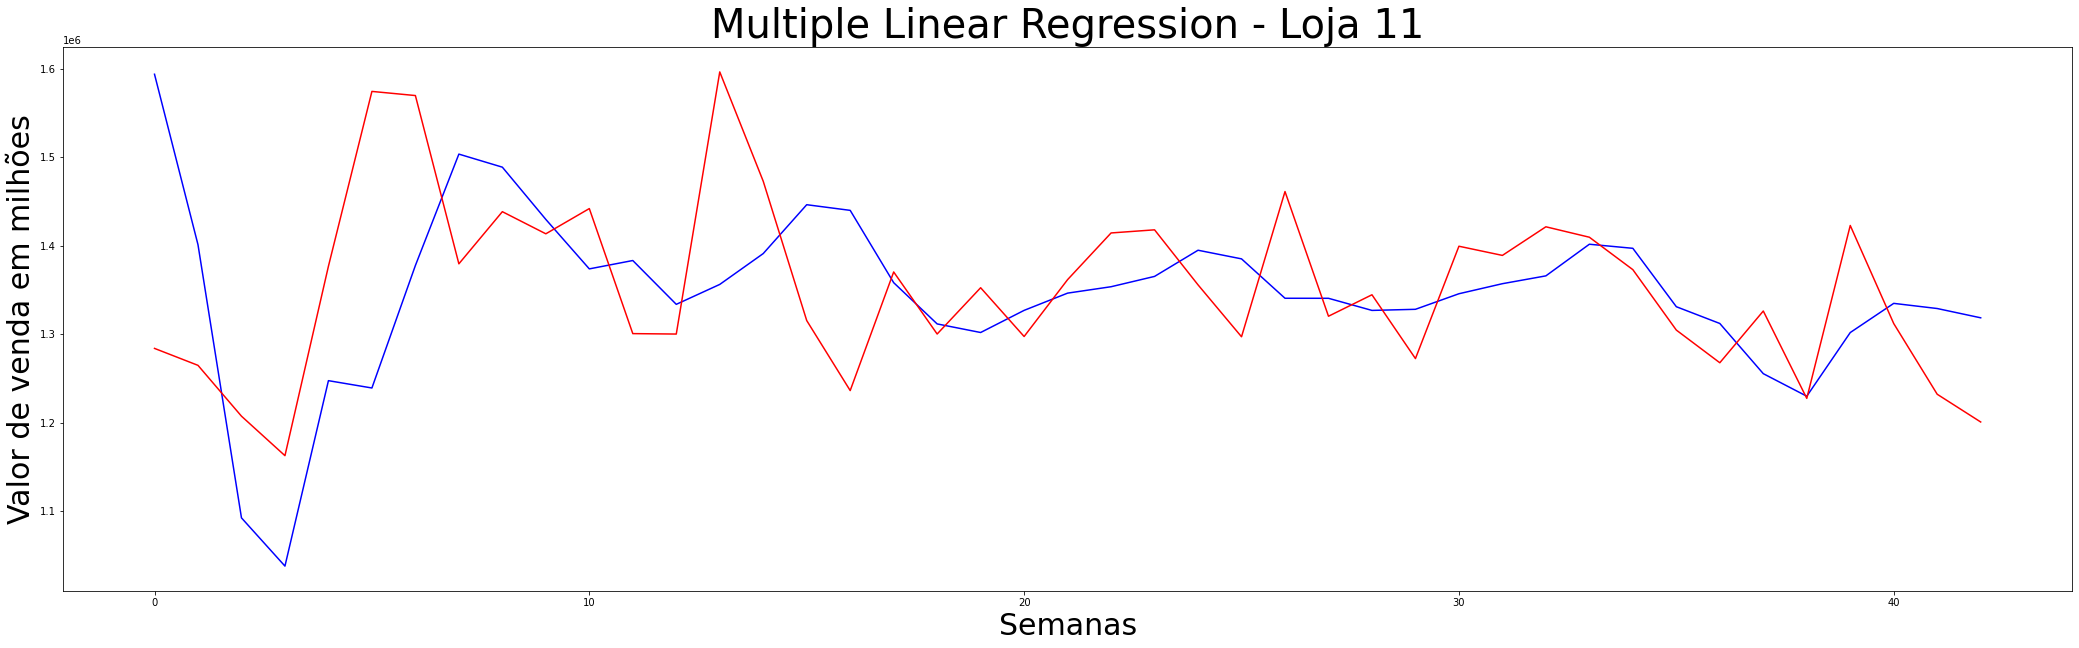

**************************************************
Resultados Loja 12:
0.03779219462318051 57629.63 84035.93


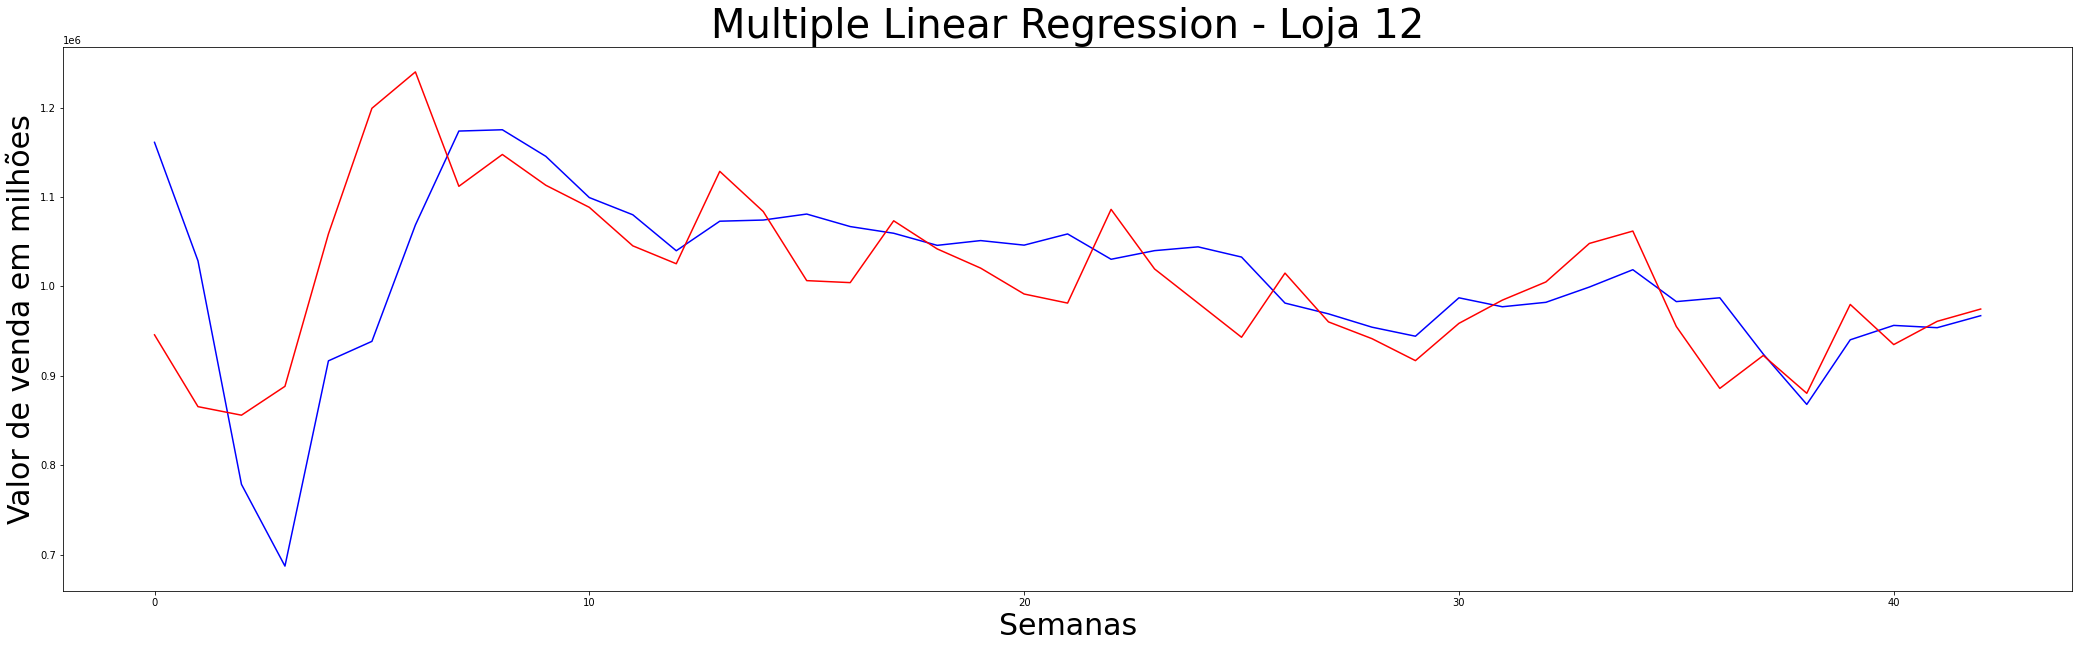

**************************************************
Resultados Loja 13:
-1.3836538705410892 113262.83 169018.25


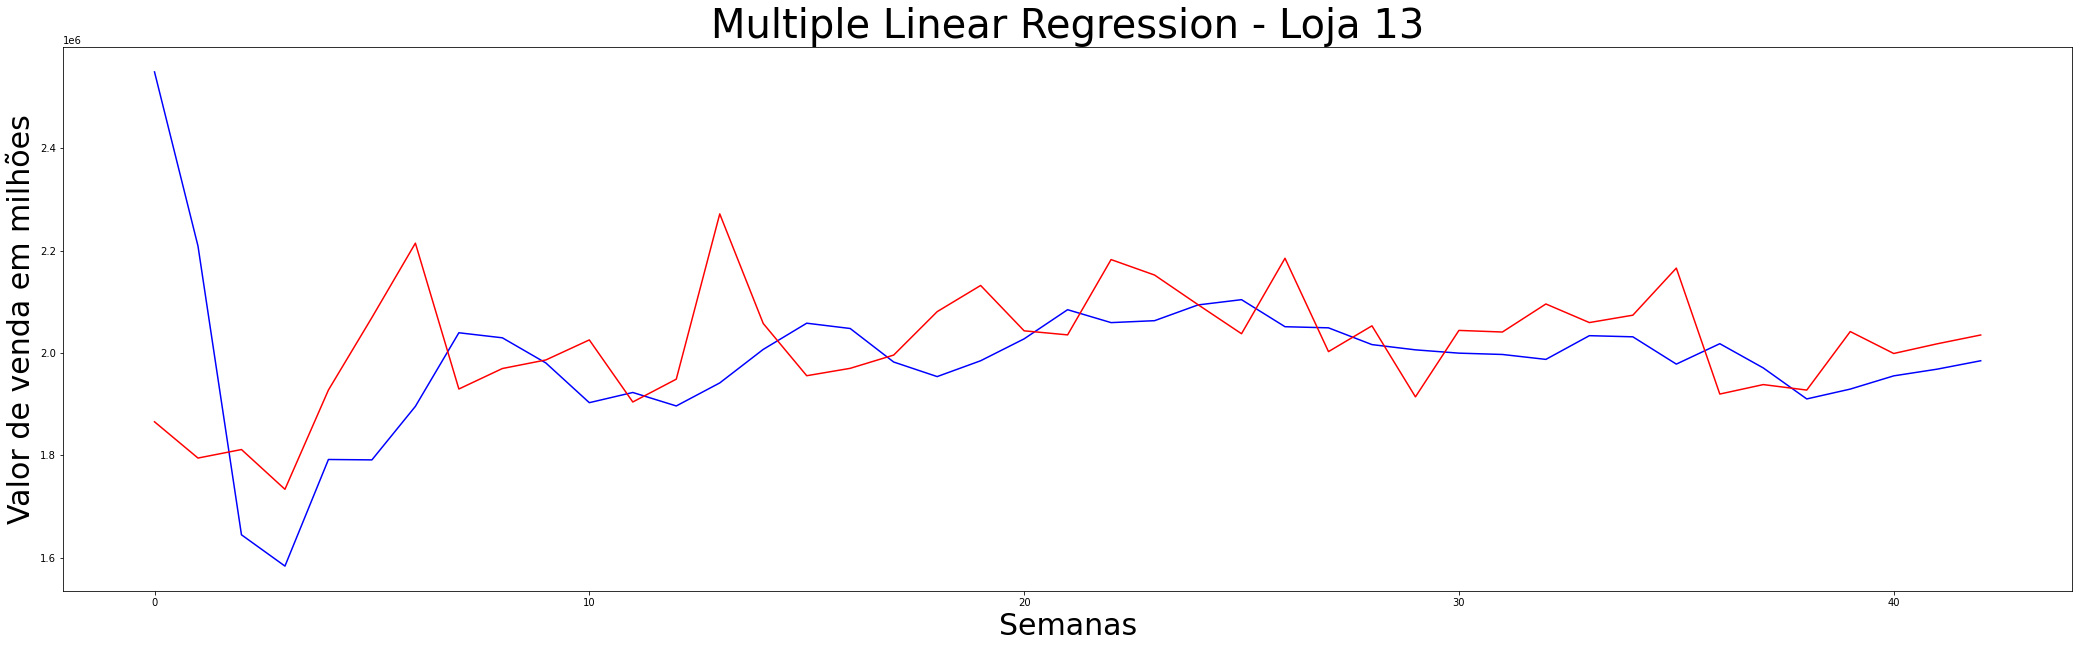

**************************************************
Resultados Loja 14:
0.044243713886089275 143611.11 192048.64


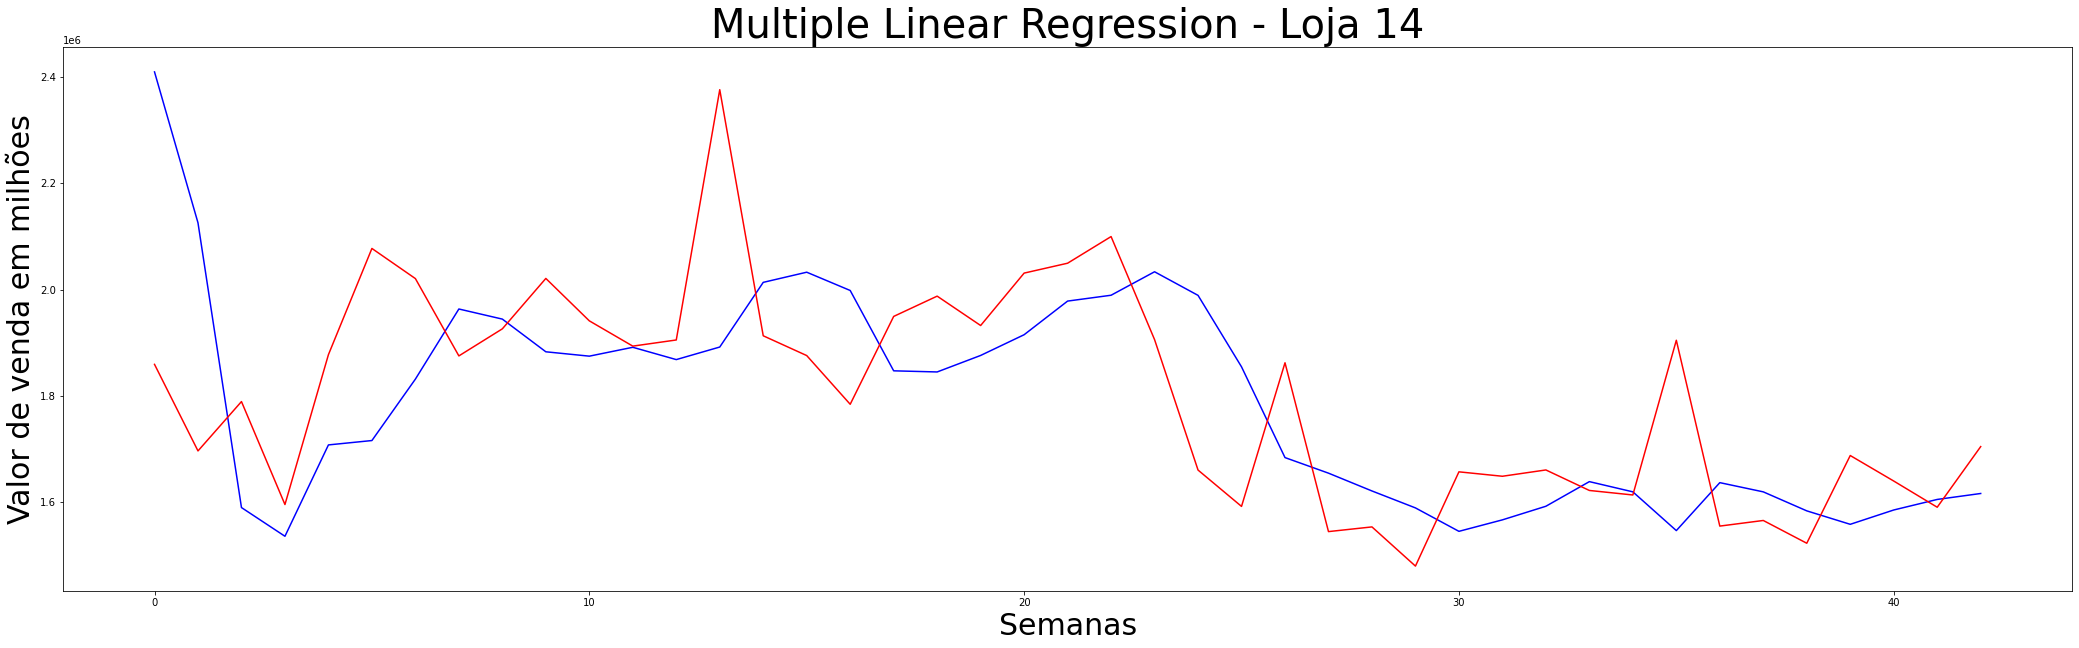

**************************************************
Resultados Loja 15:
-0.6887181636936517 51920.777 68353.67


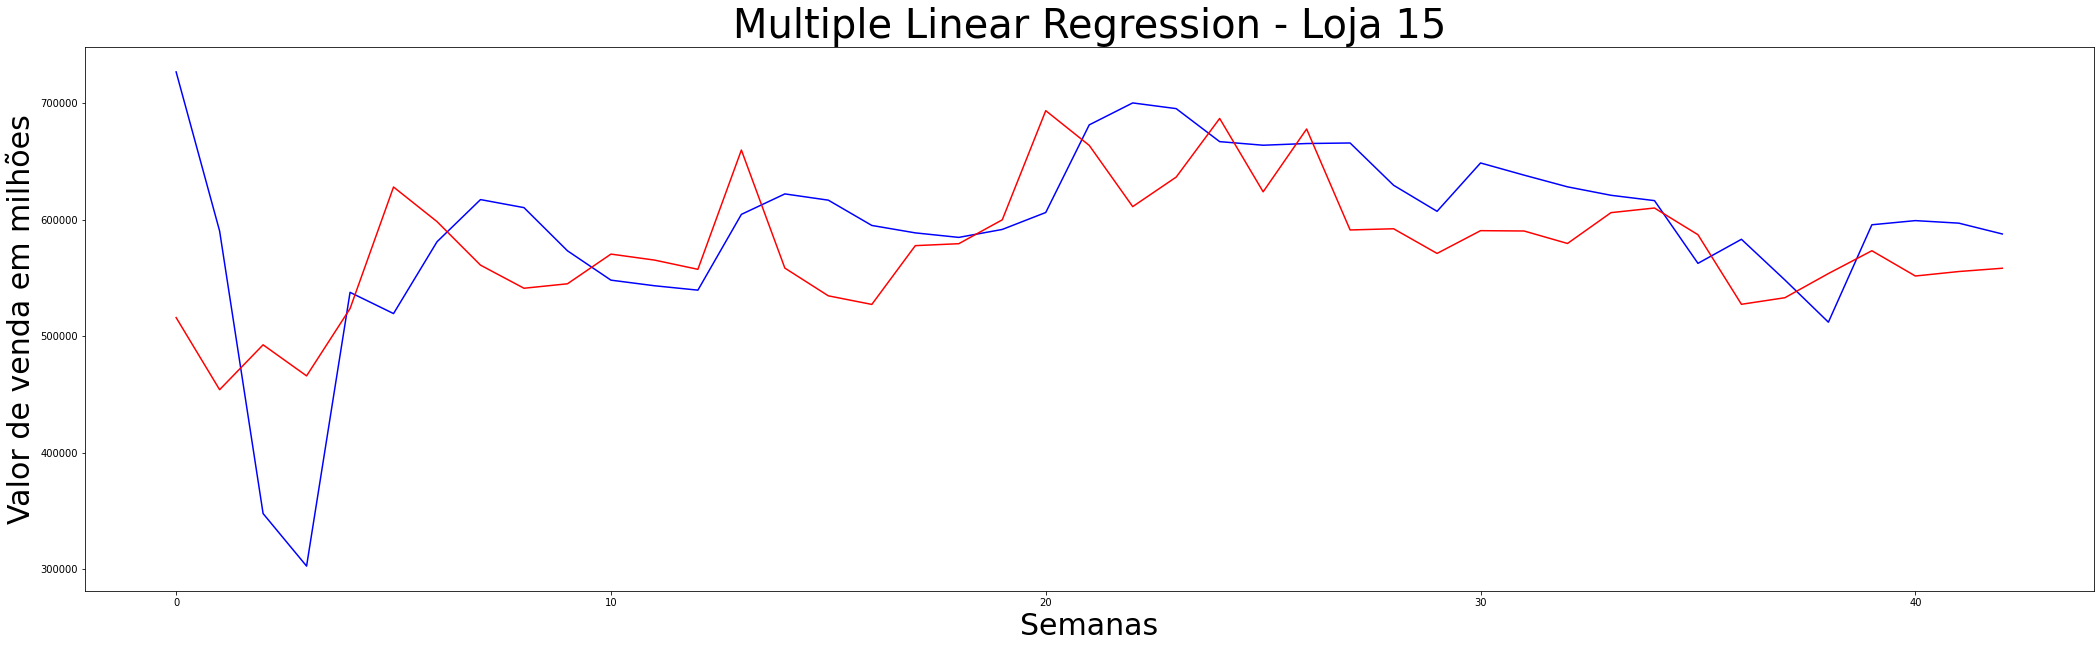

**************************************************
Resultados Loja 16:
0.08737662592818352 40472.45 48335.176


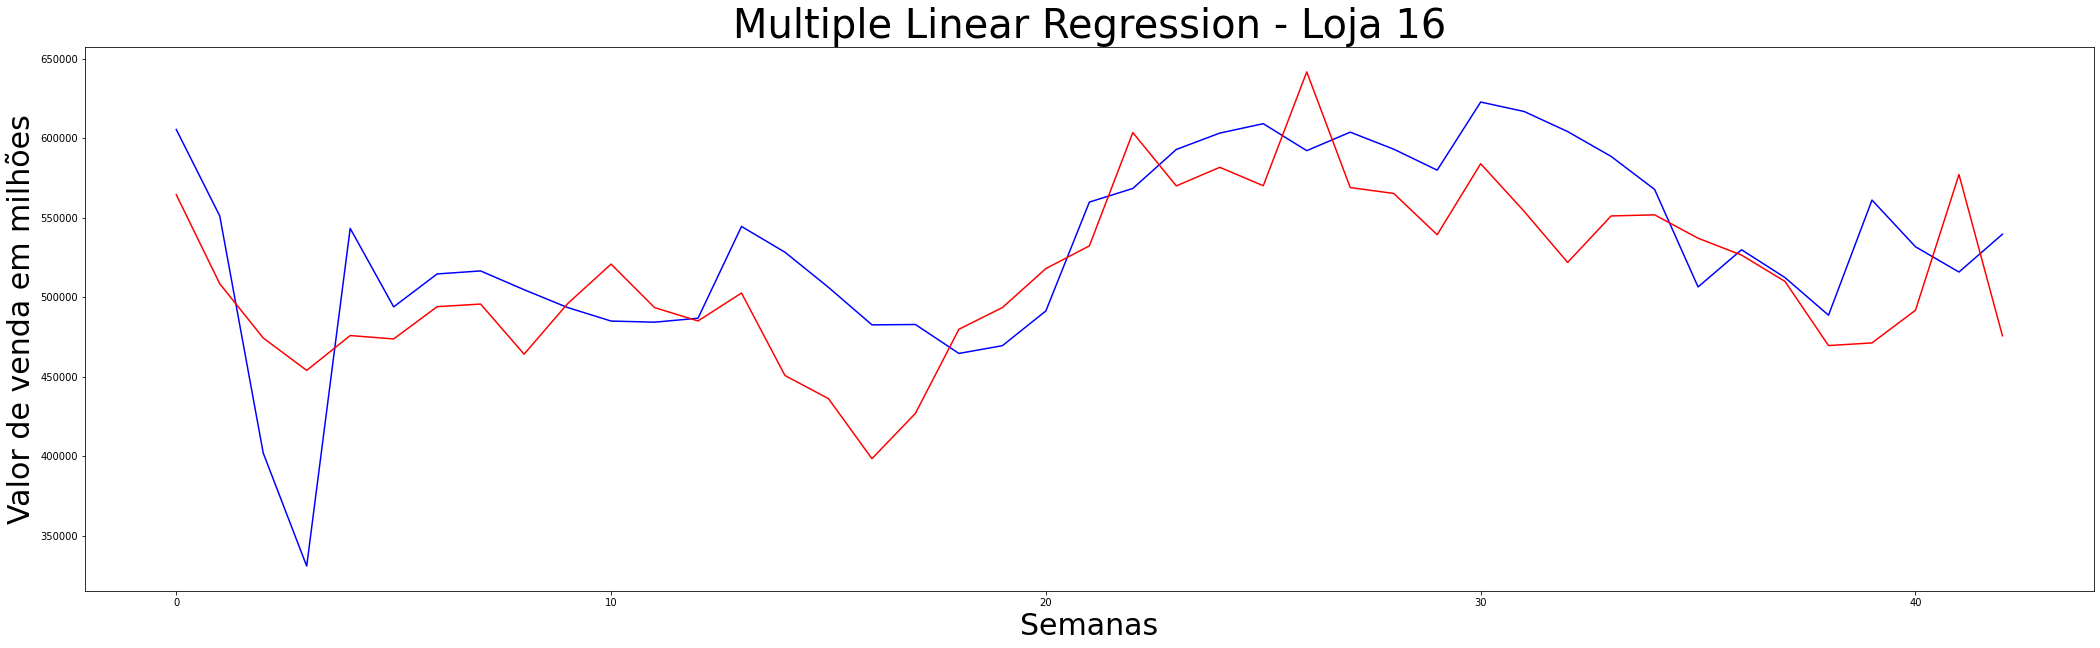

**************************************************
Resultados Loja 17:
-0.17657856737135535 64678.312 101341.195


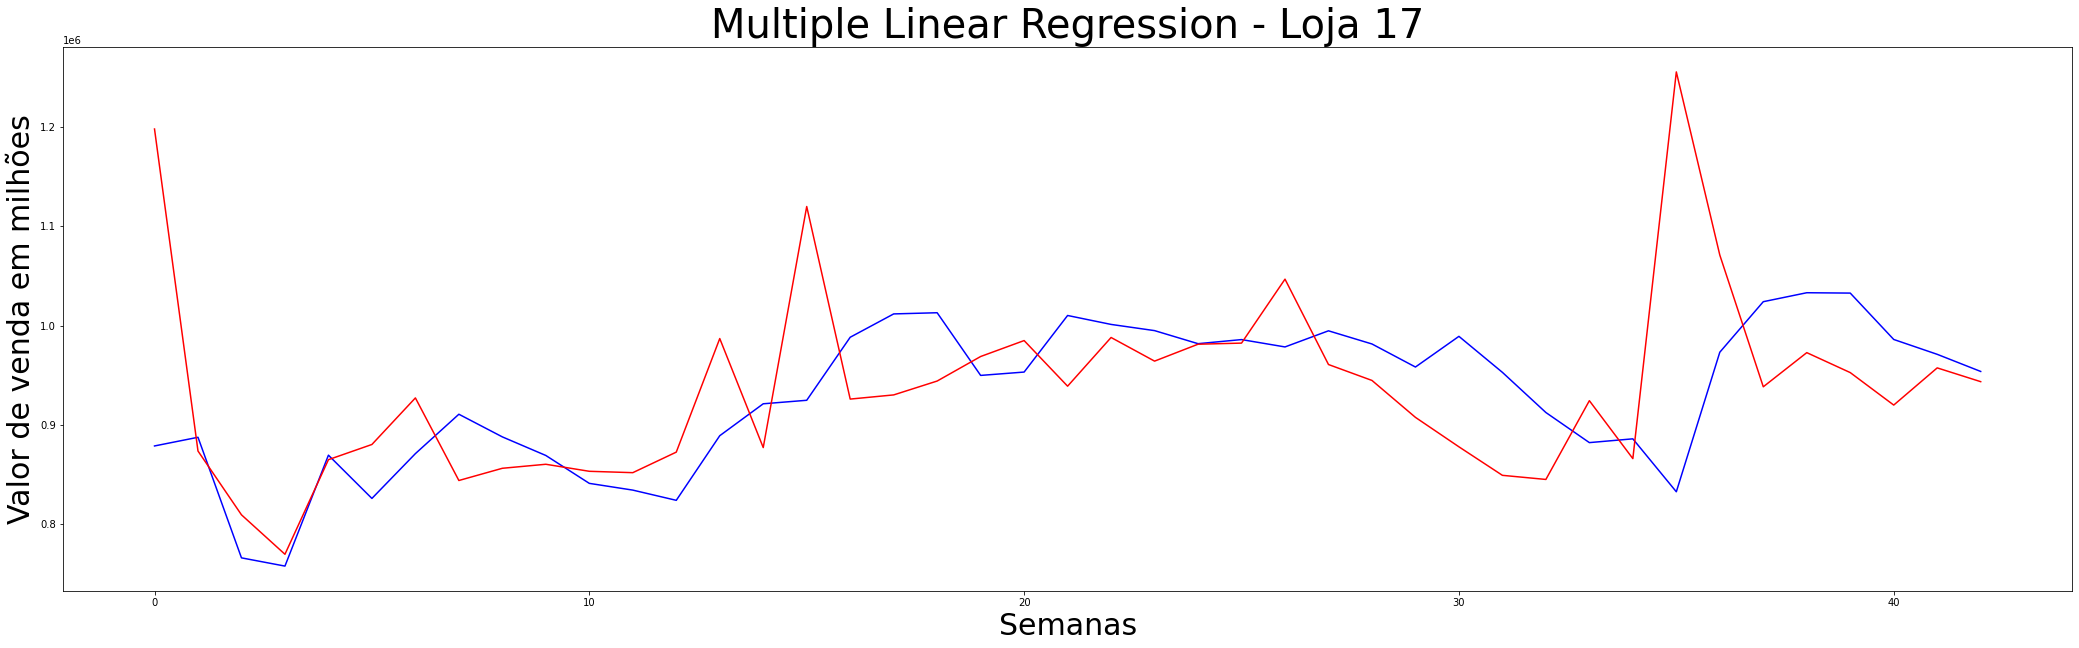

**************************************************
Resultados Loja 18:
-0.6529092518449107 70655.92 95126.39


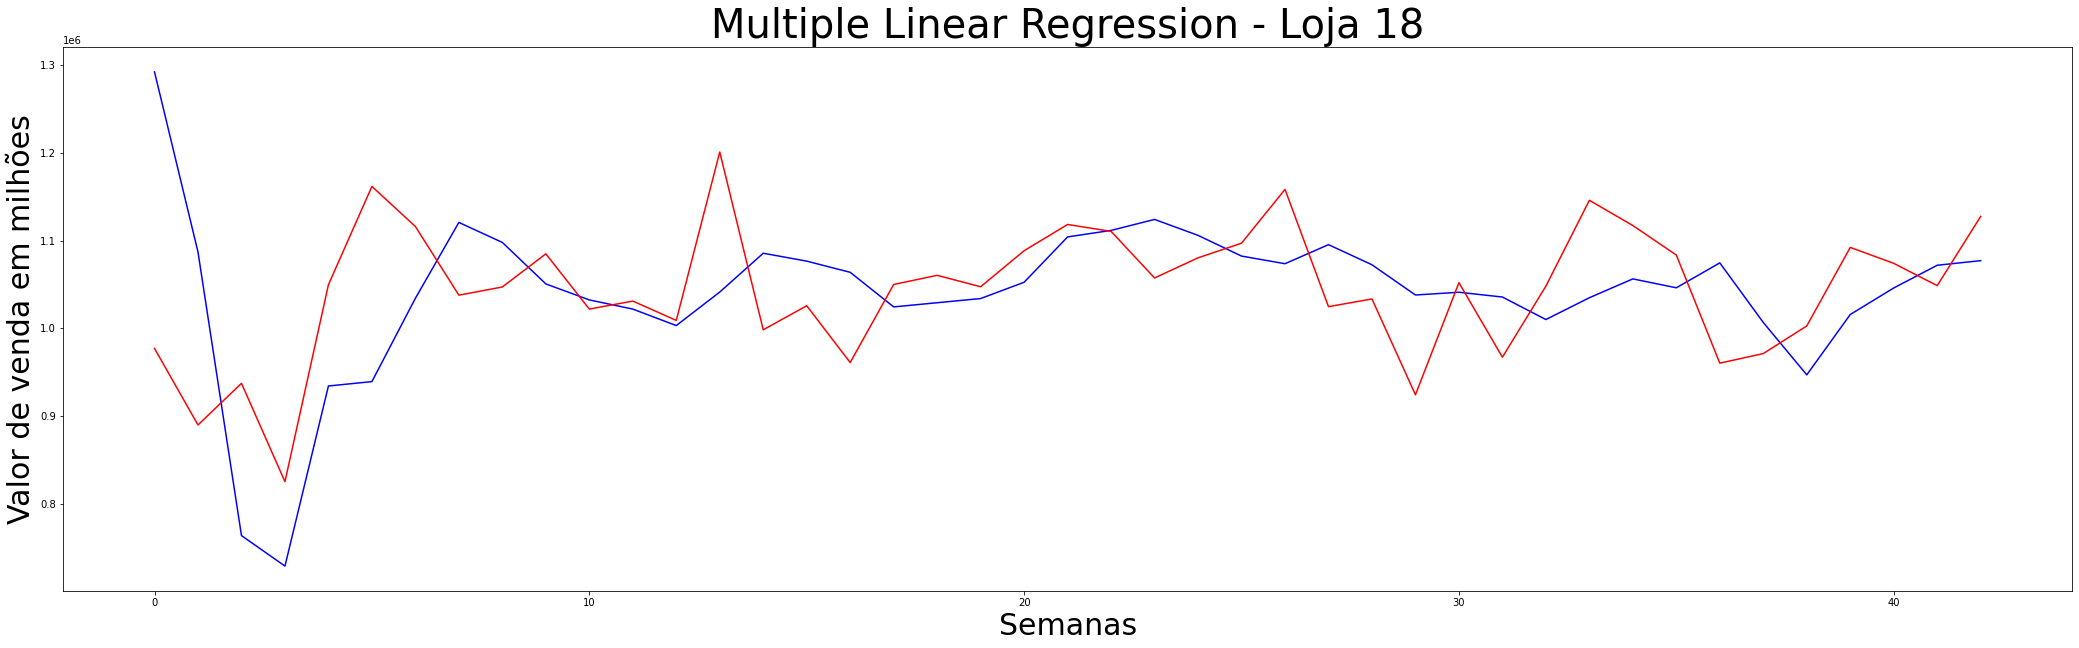

**************************************************
Resultados Loja 19:
-1.0942805145352001 97088.27 134668.38


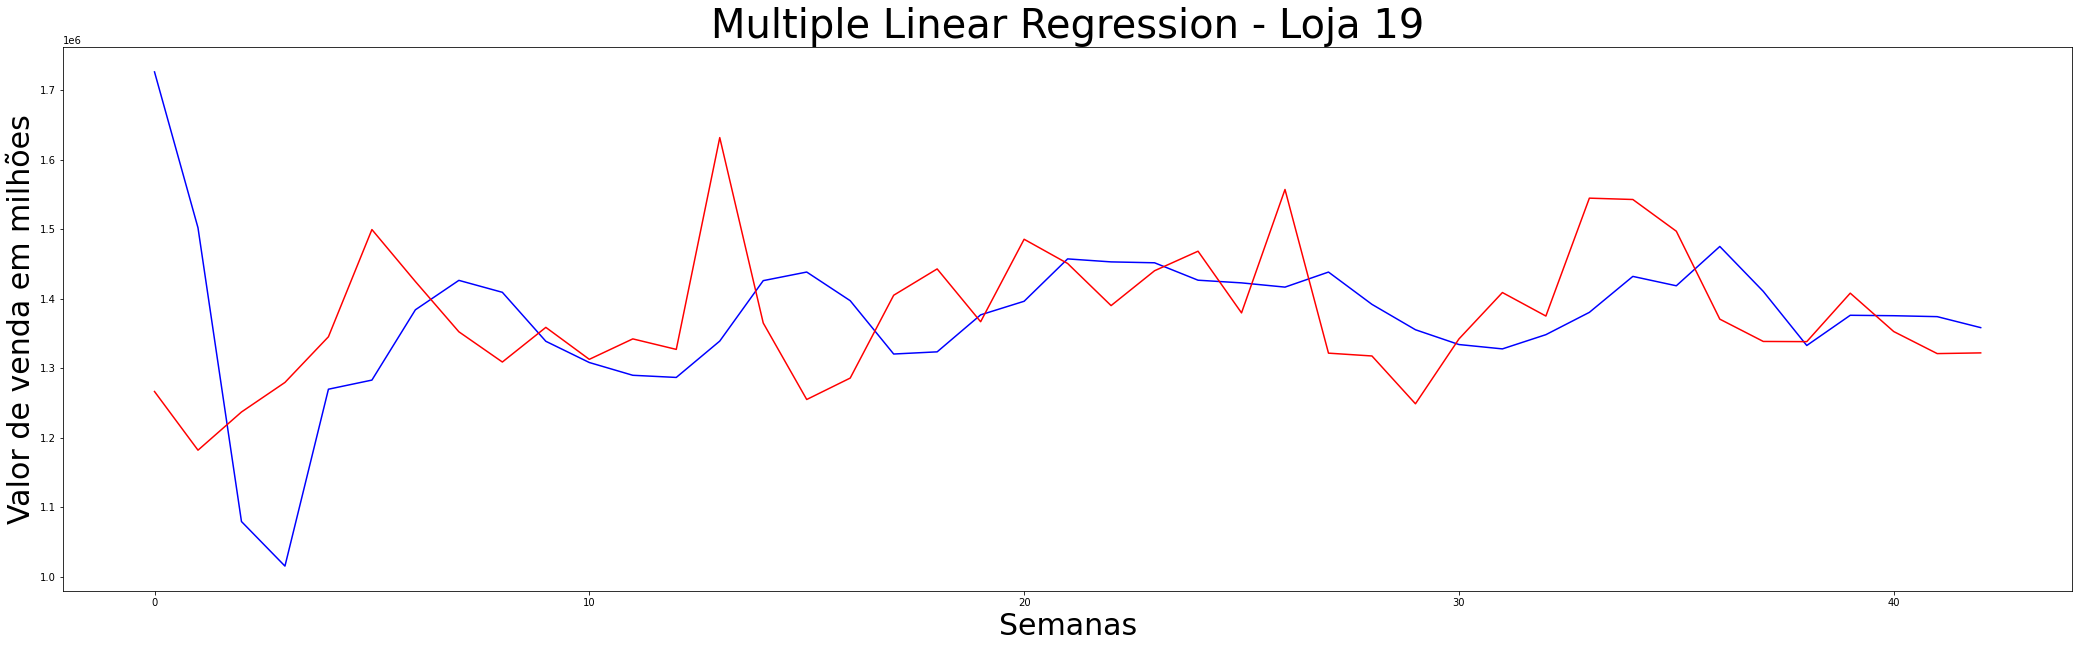

**************************************************
Resultados Loja 20:
-1.0320078974776101 155020.06 212590.16


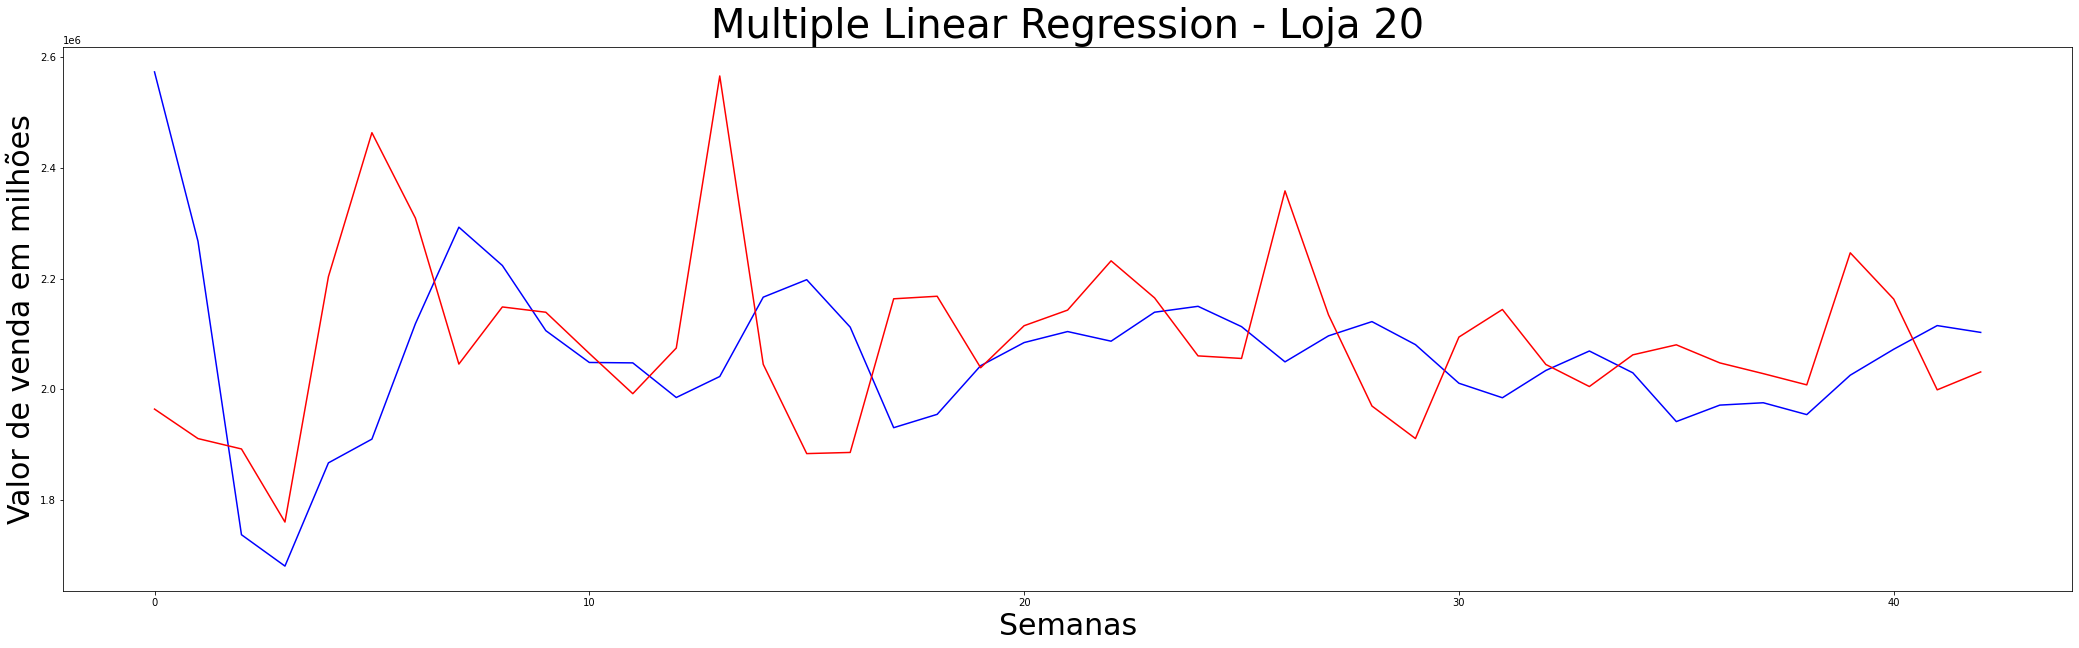

**************************************************
Resultados Loja 21:
-0.9541440560478145 49782.12 71522.79


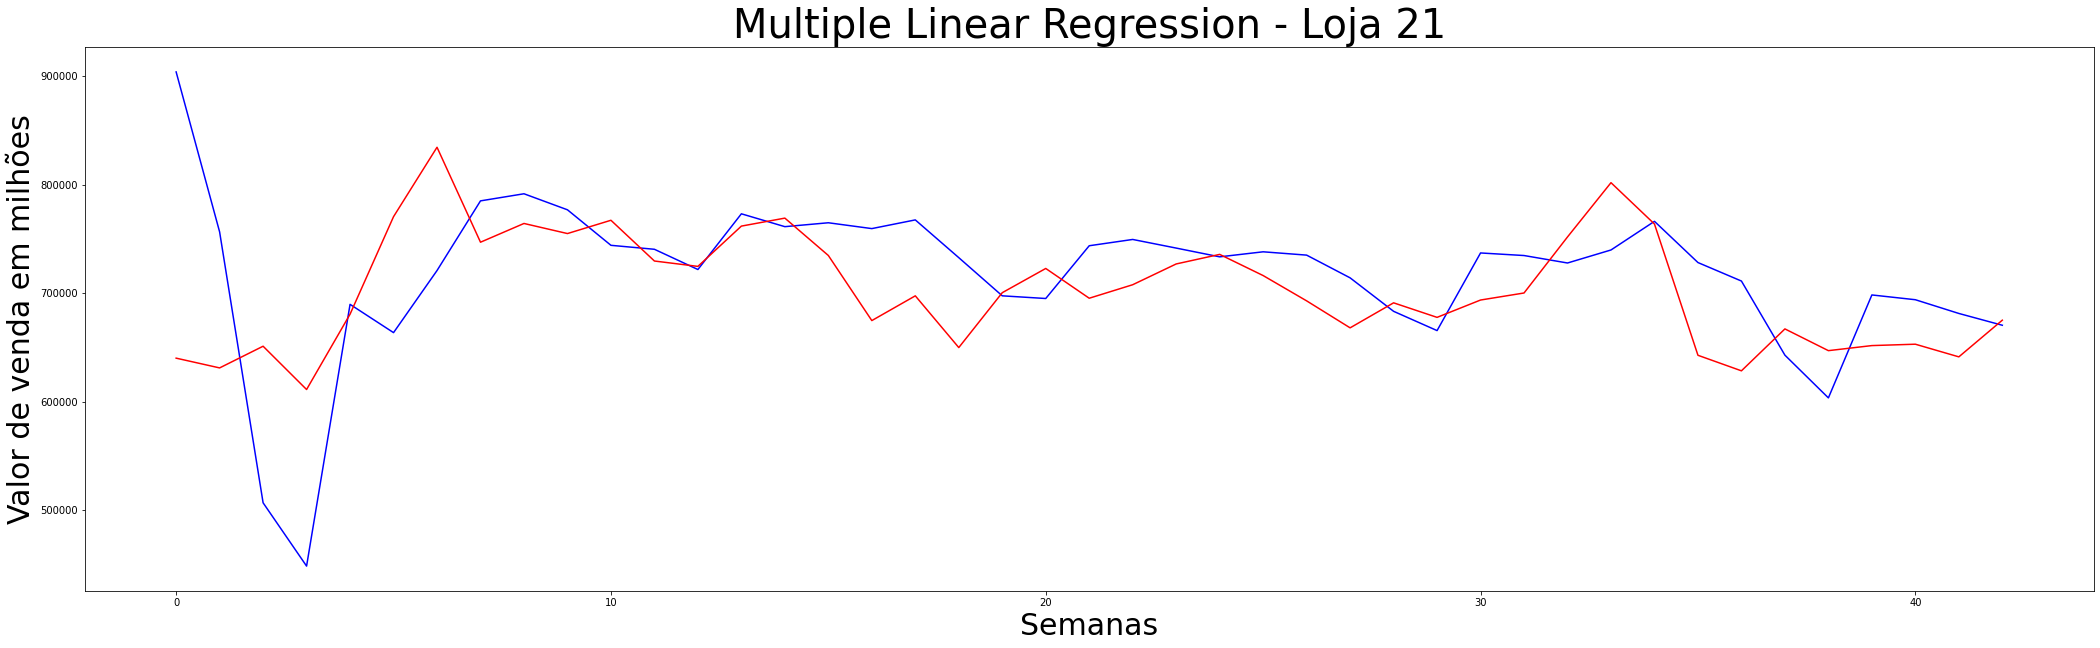

**************************************************
Resultados Loja 22:
-0.6473638770707786 63712.5 93420.24


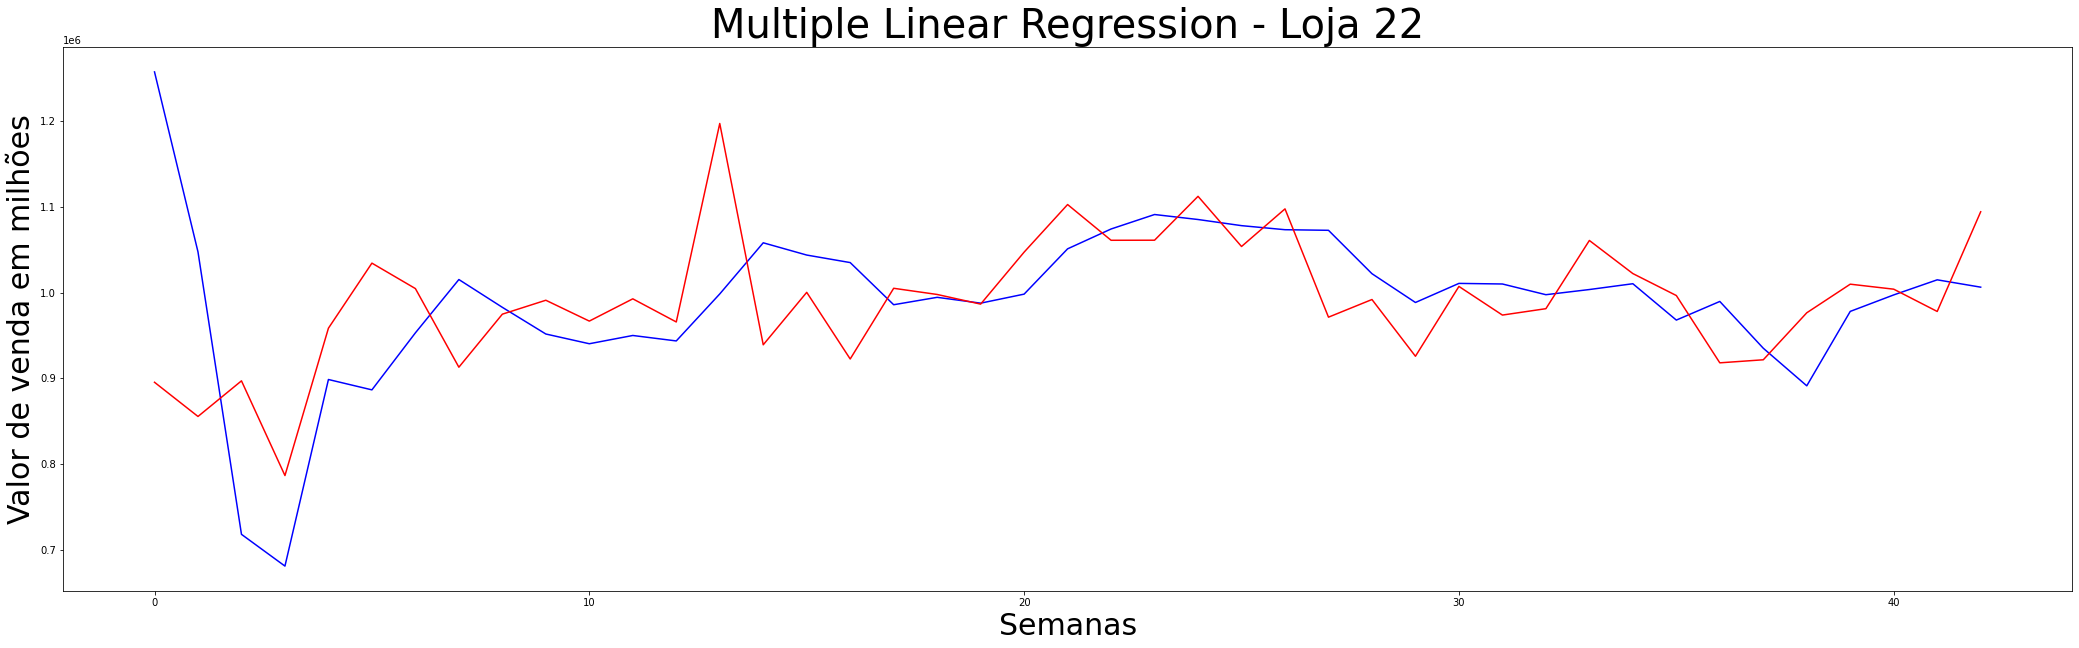

**************************************************
Resultados Loja 23:
-0.3245536586270905 106971.305 162956.58


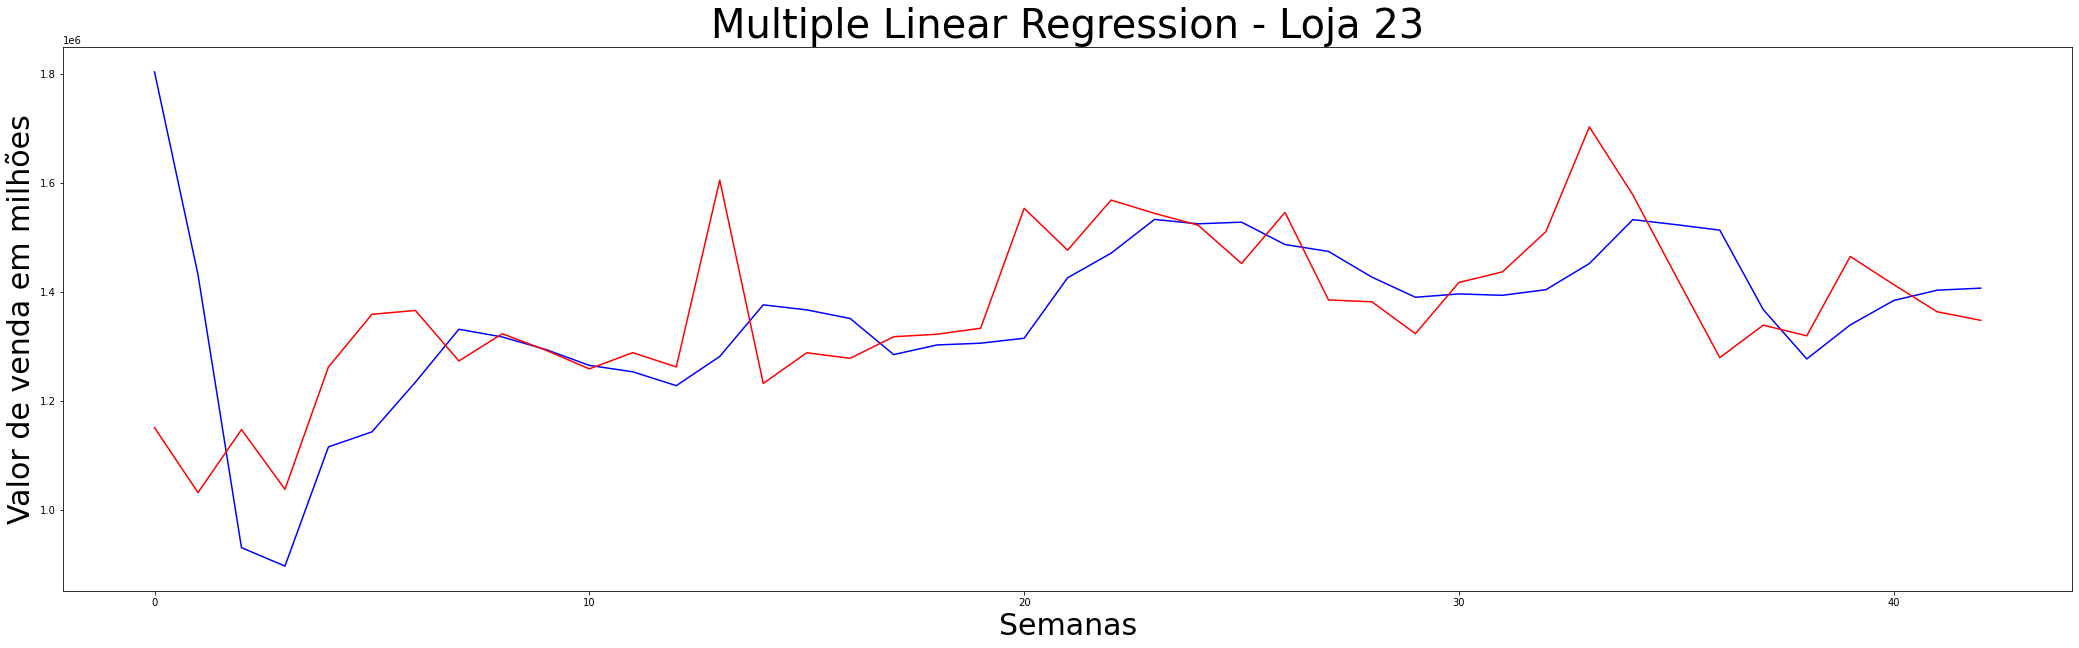

**************************************************
Resultados Loja 24:
-0.11870745271824235 92850.89 118728.61


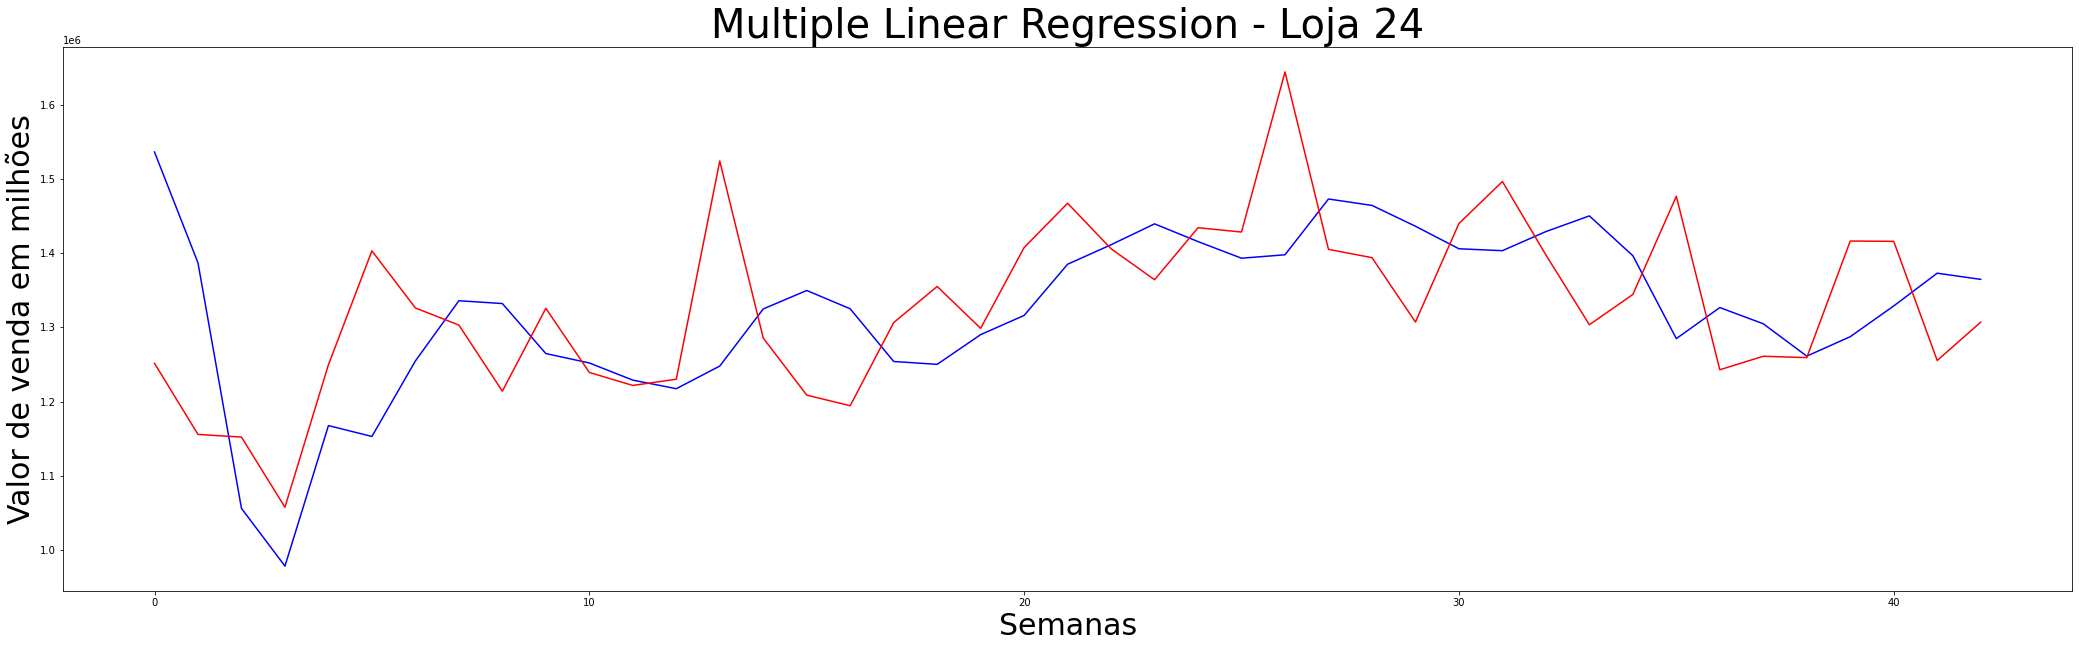

**************************************************
Resultados Loja 25:
-0.6709253992808726 44177.53 59988.844


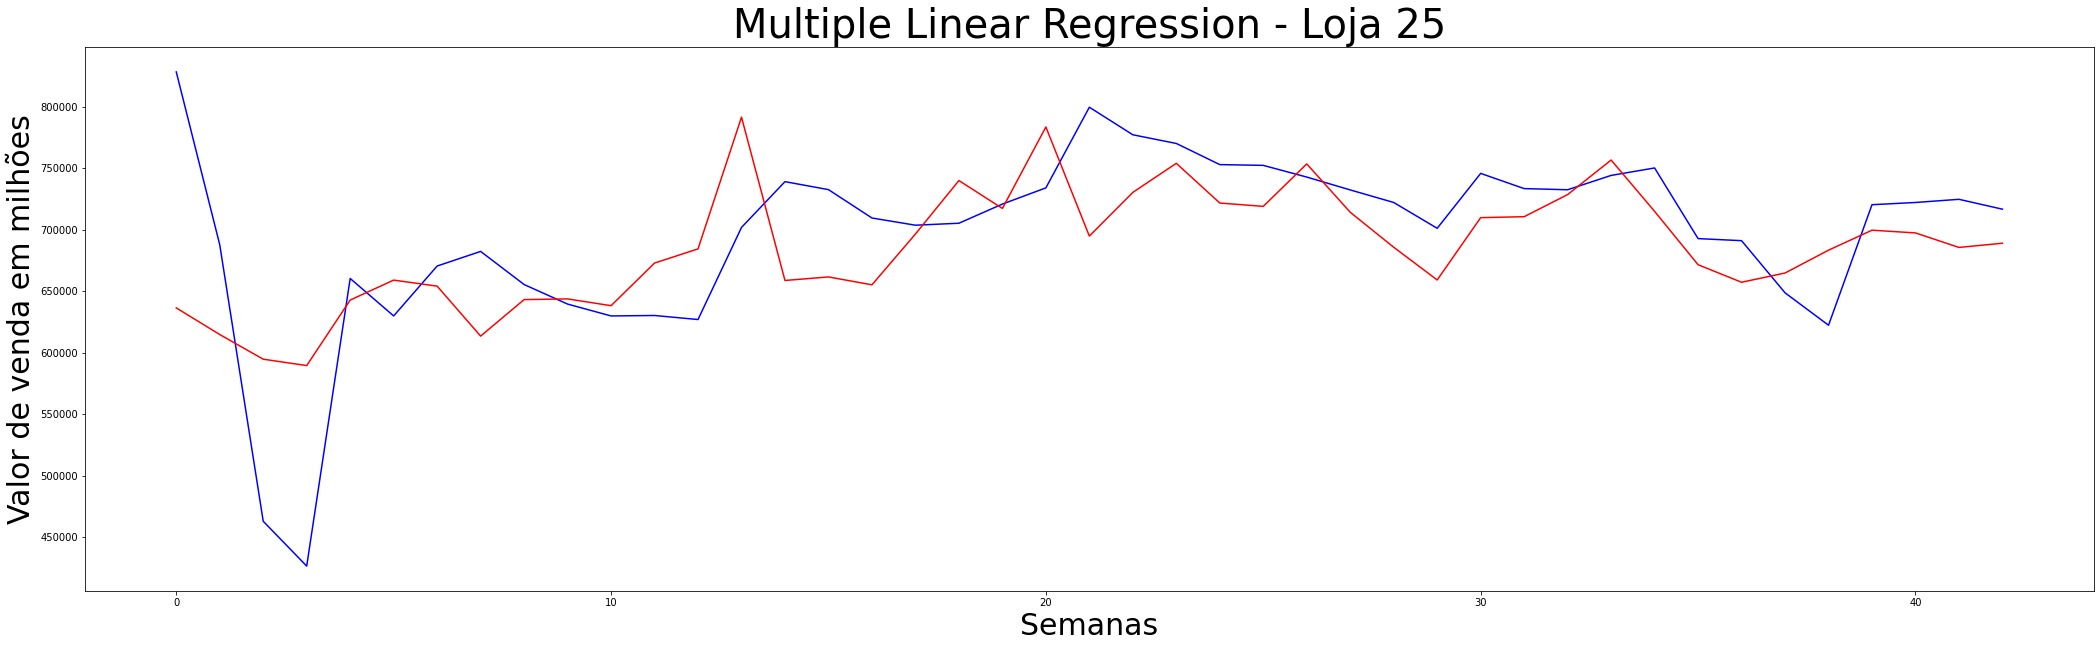

**************************************************
Resultados Loja 26:
0.12099503820674573 62016.2 78139.26


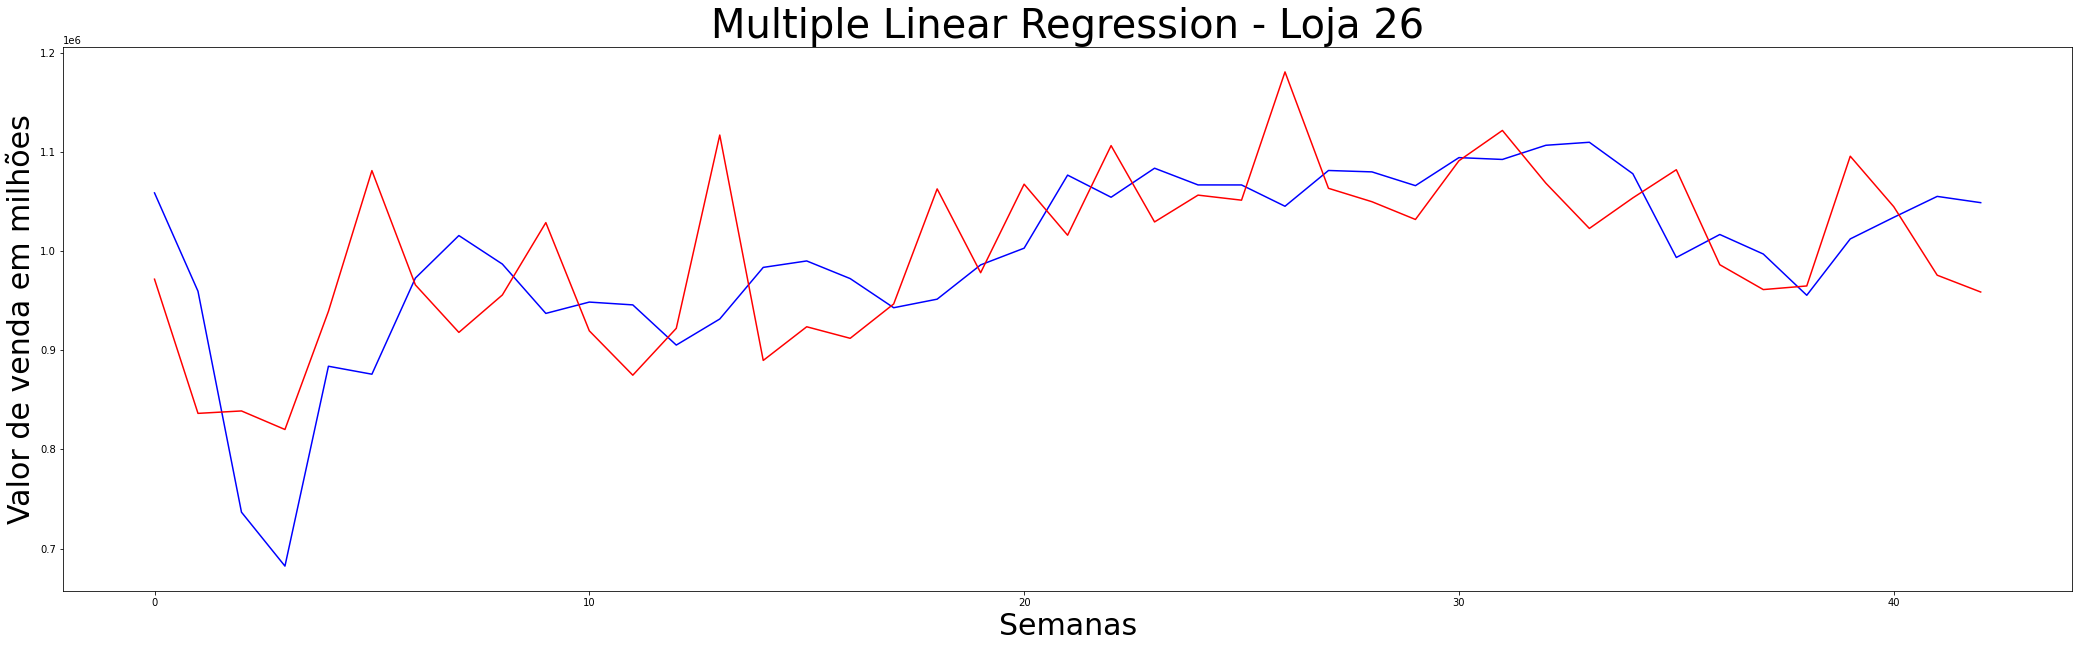

**************************************************
Resultados Loja 27:
-0.04332286055089618 105540.164 137955.58


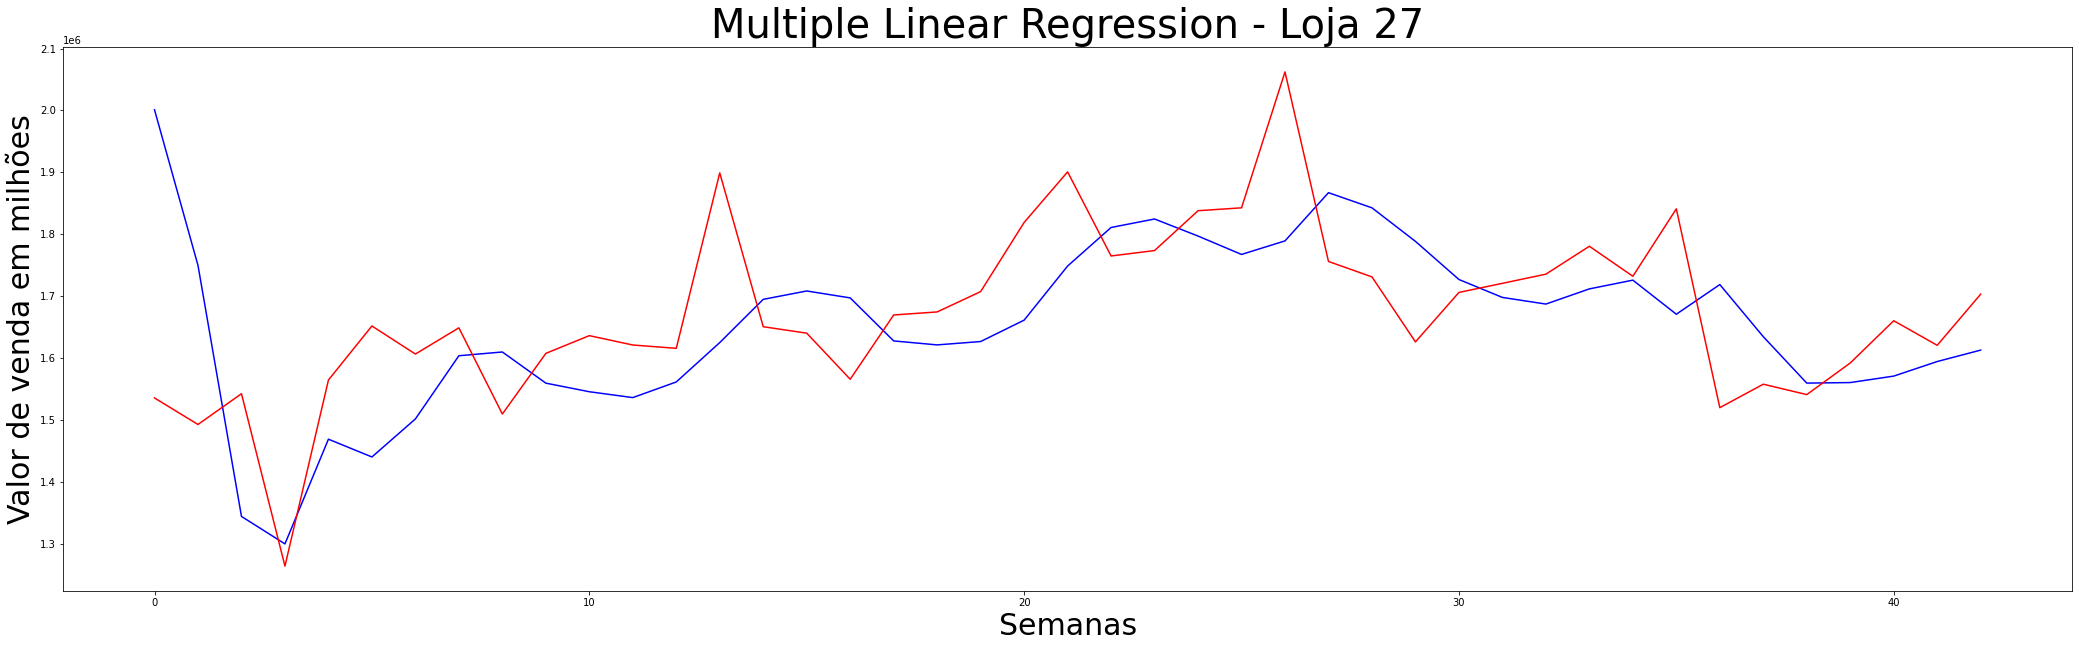

**************************************************
Resultados Loja 28:
-0.23394426062935048 138373.52 169127.25


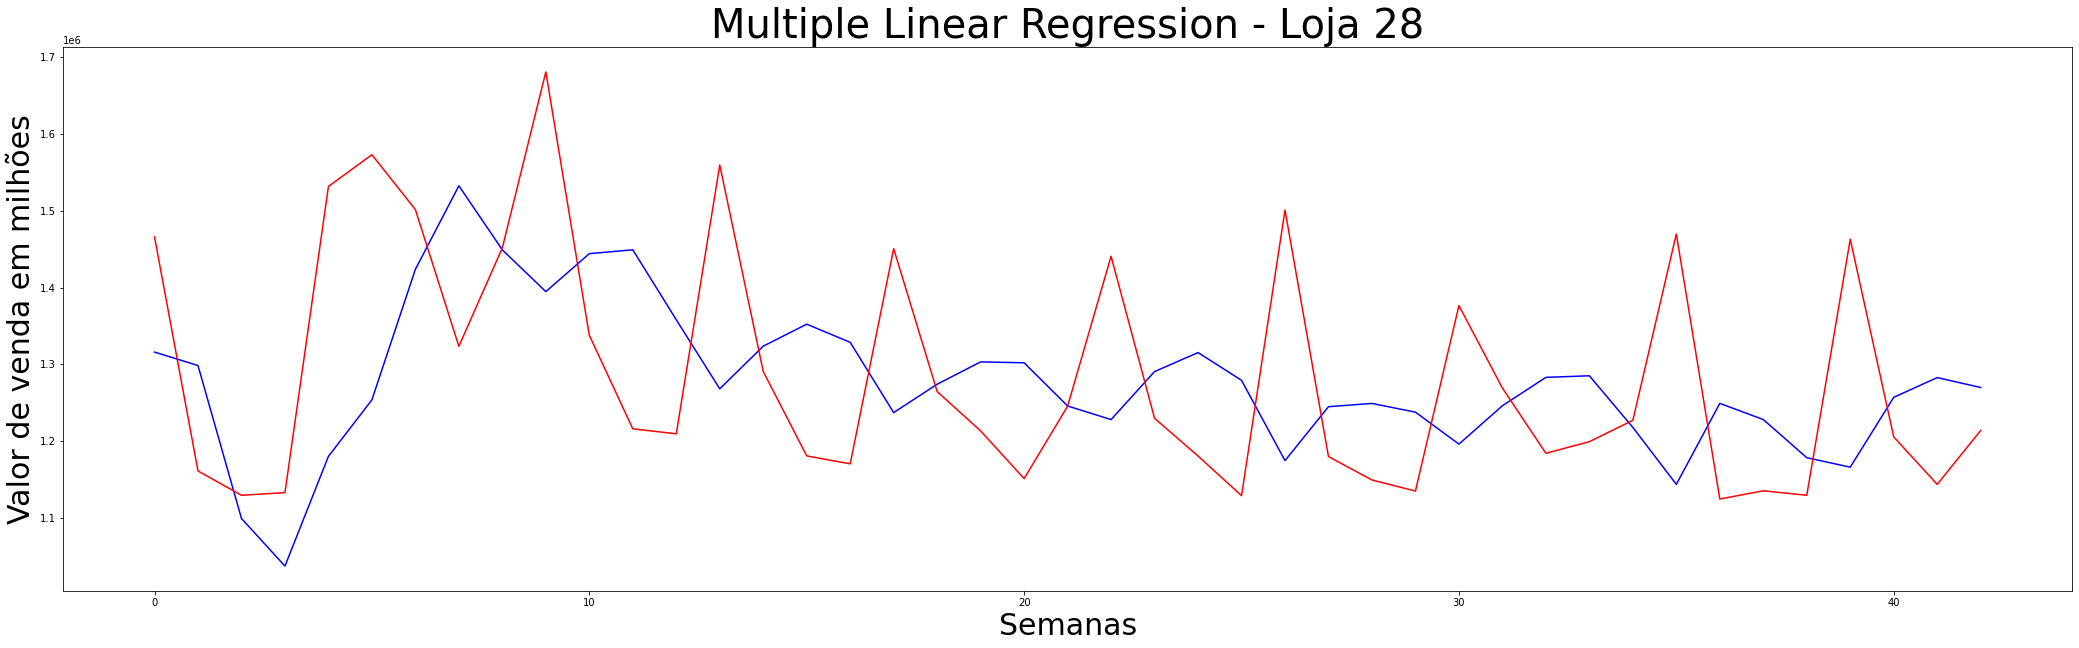

**************************************************
Resultados Loja 29:
-0.6670233984560738 46366.83 59368.2


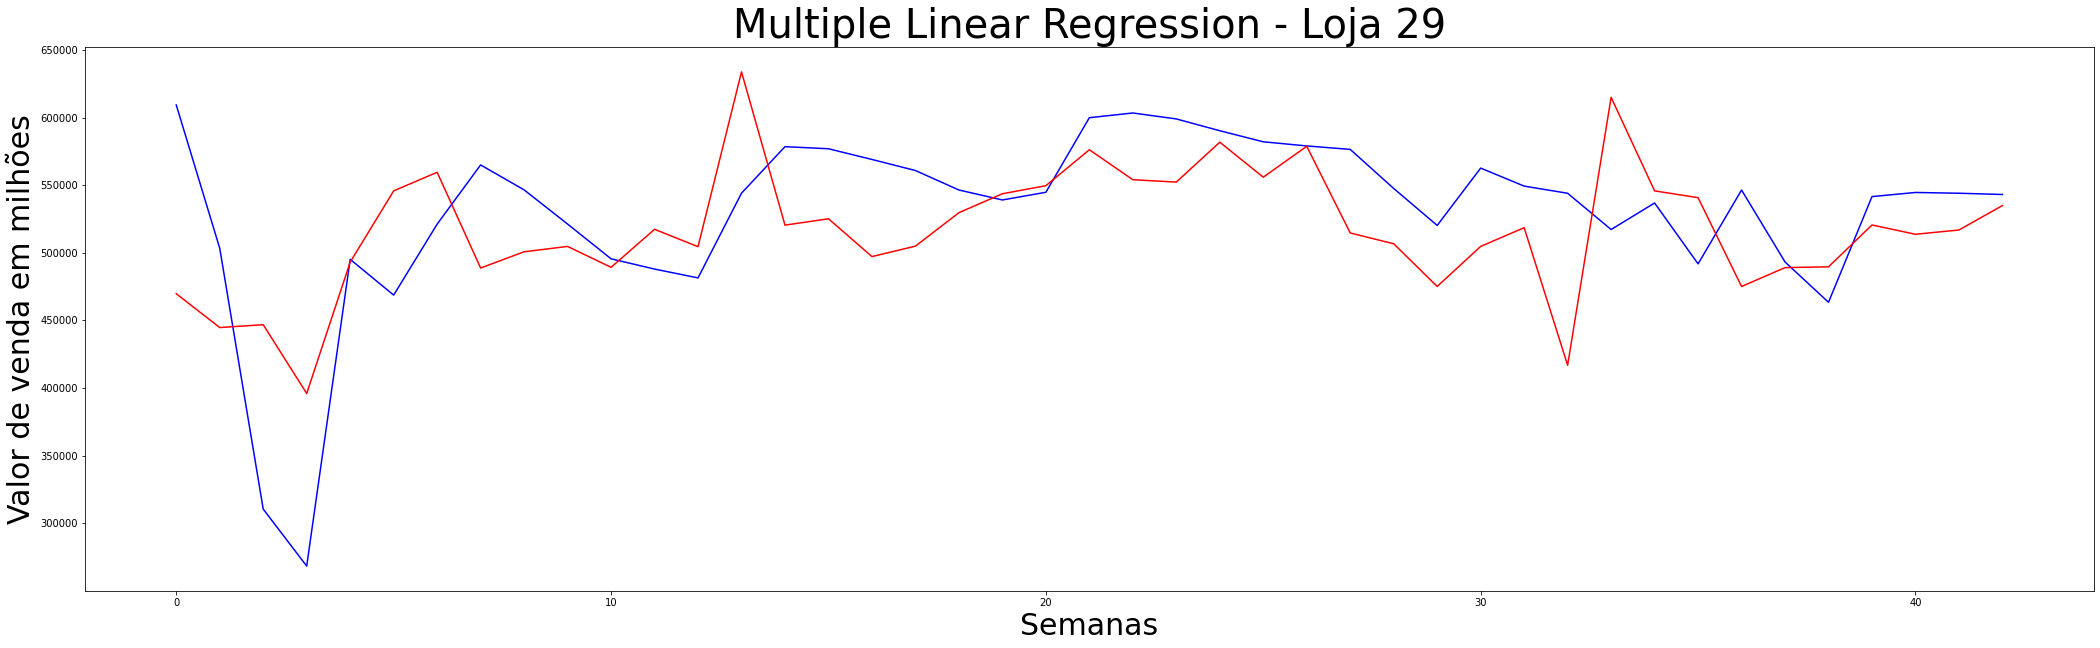

**************************************************
Resultados Loja 30:
-30.207505781374604 47442.027 65491.84


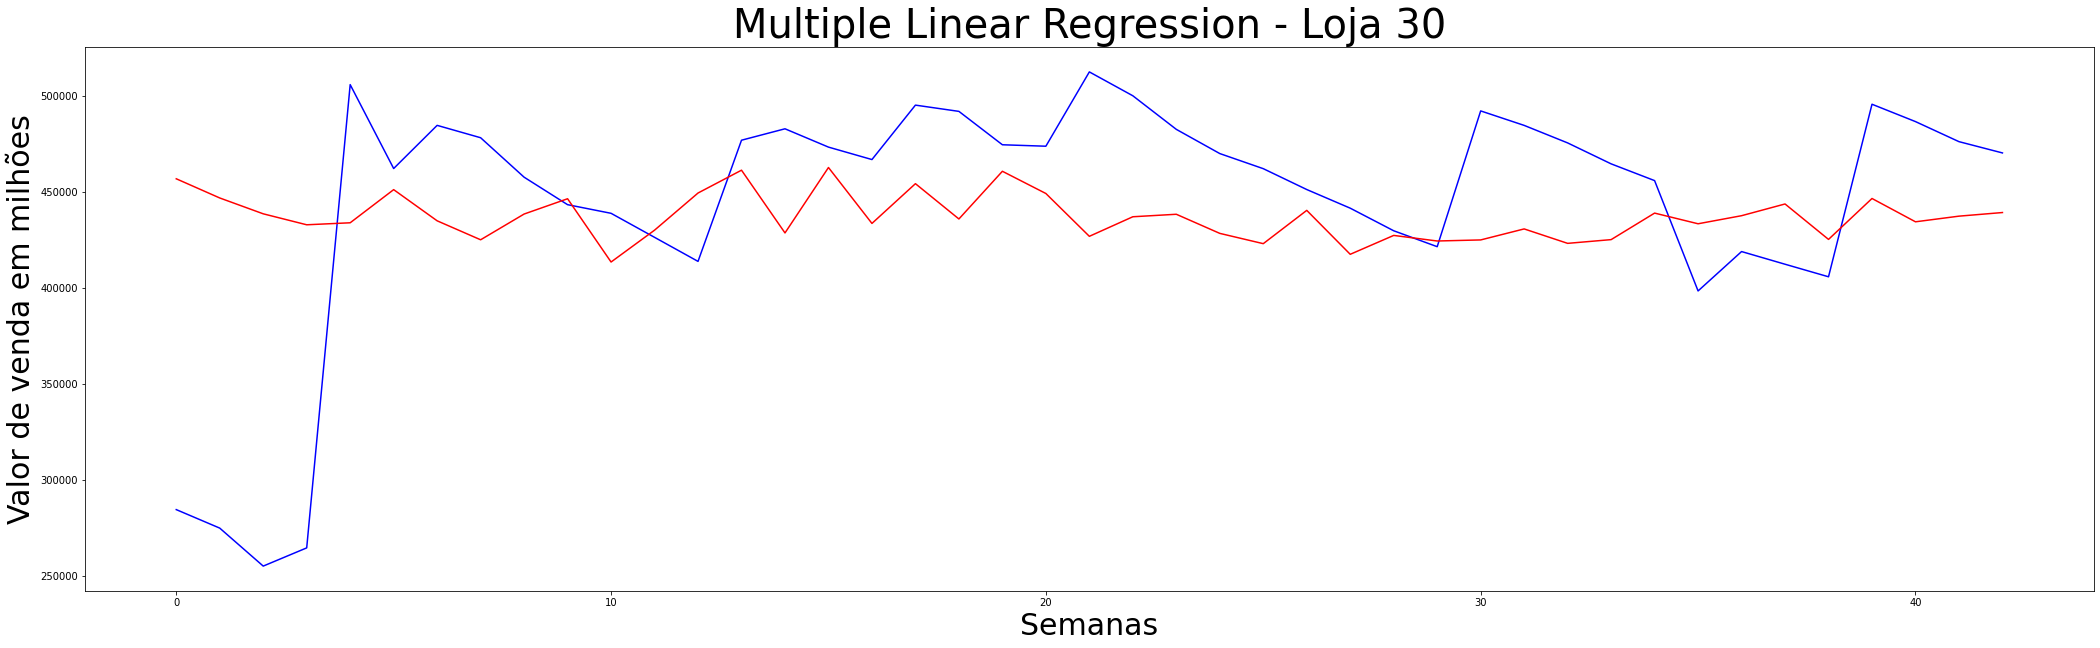

**************************************************
Resultados Loja 31:
-0.41413619345959973 48392.11 69763.414


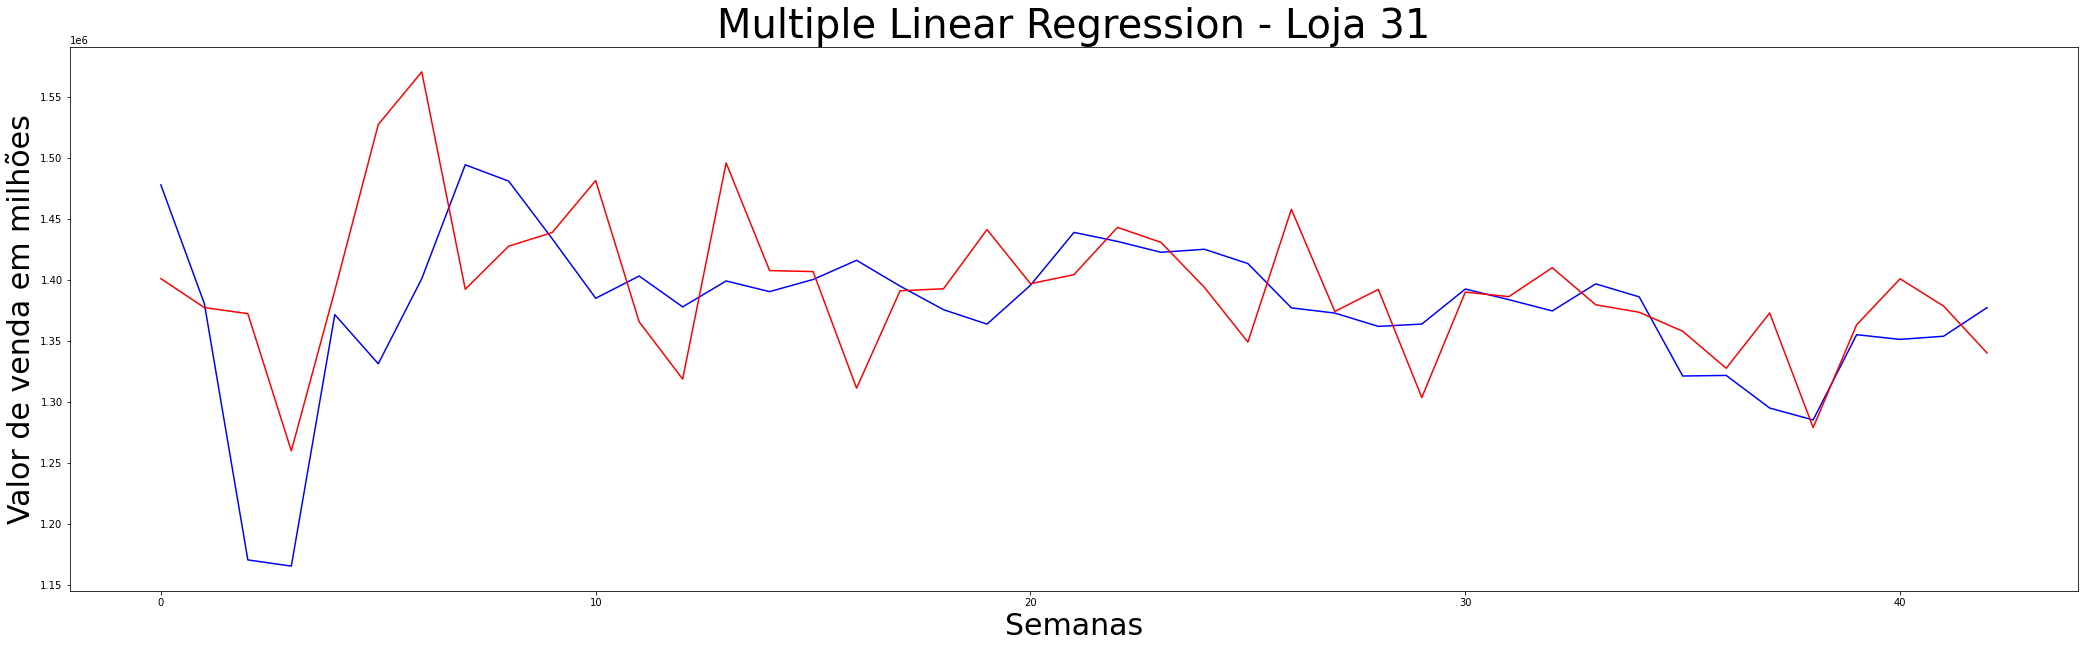

**************************************************
Resultados Loja 32:
-0.9429925787425213 51599.105 73755.48


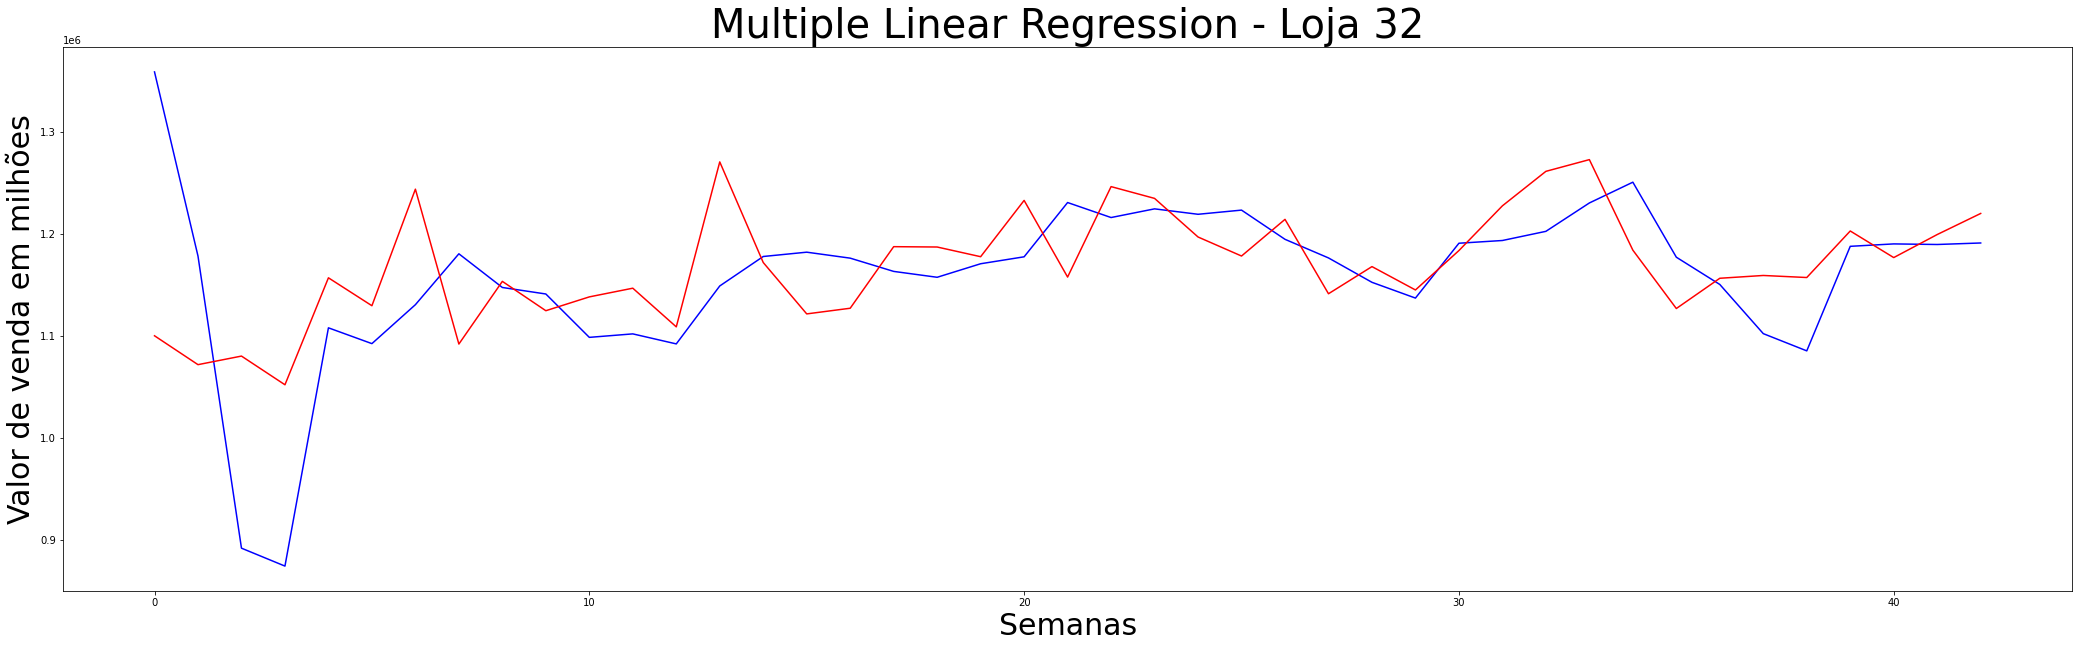

**************************************************
Resultados Loja 33:
-12.87684075162622 52745.273 68232.625


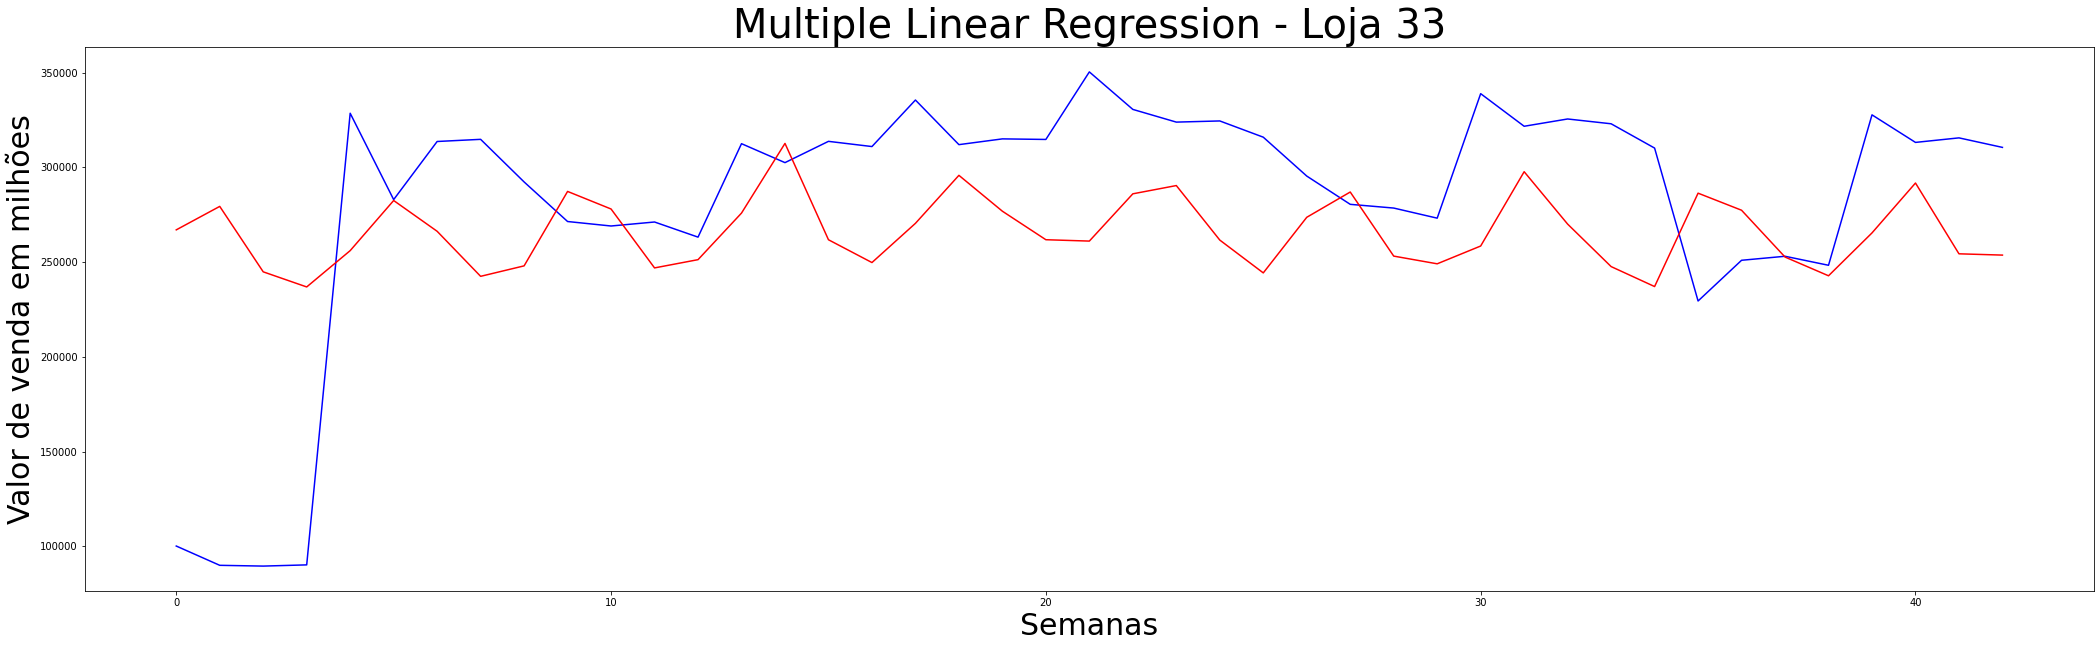

**************************************************
Resultados Loja 34:
-0.9783818151941608 46693.812 63299.76


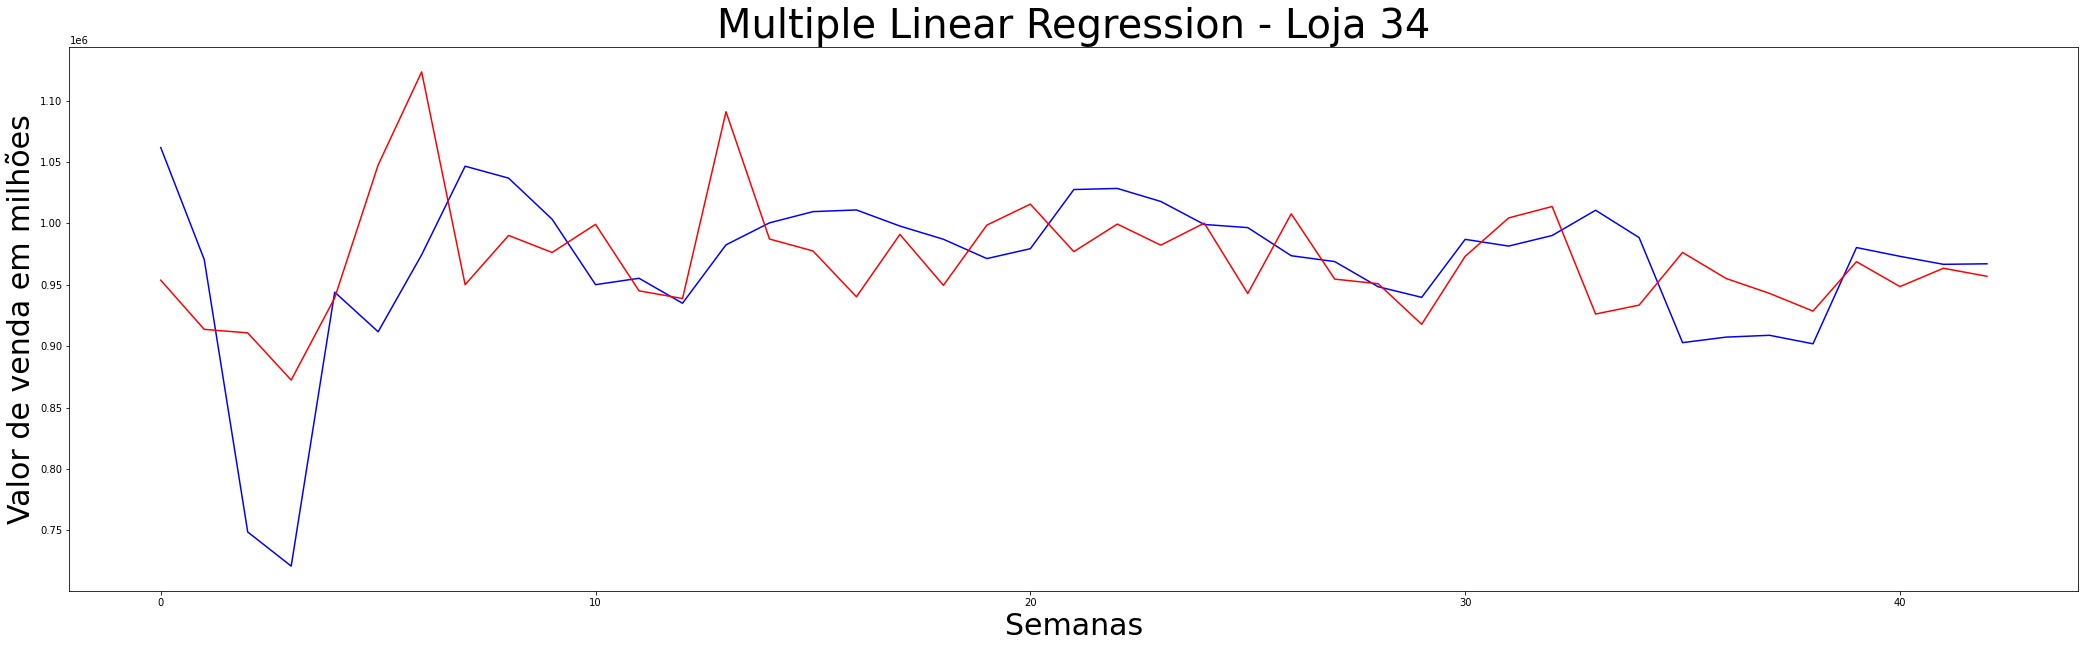

**************************************************
Resultados Loja 35:
-0.12115632546861965 56788.168 87760.23


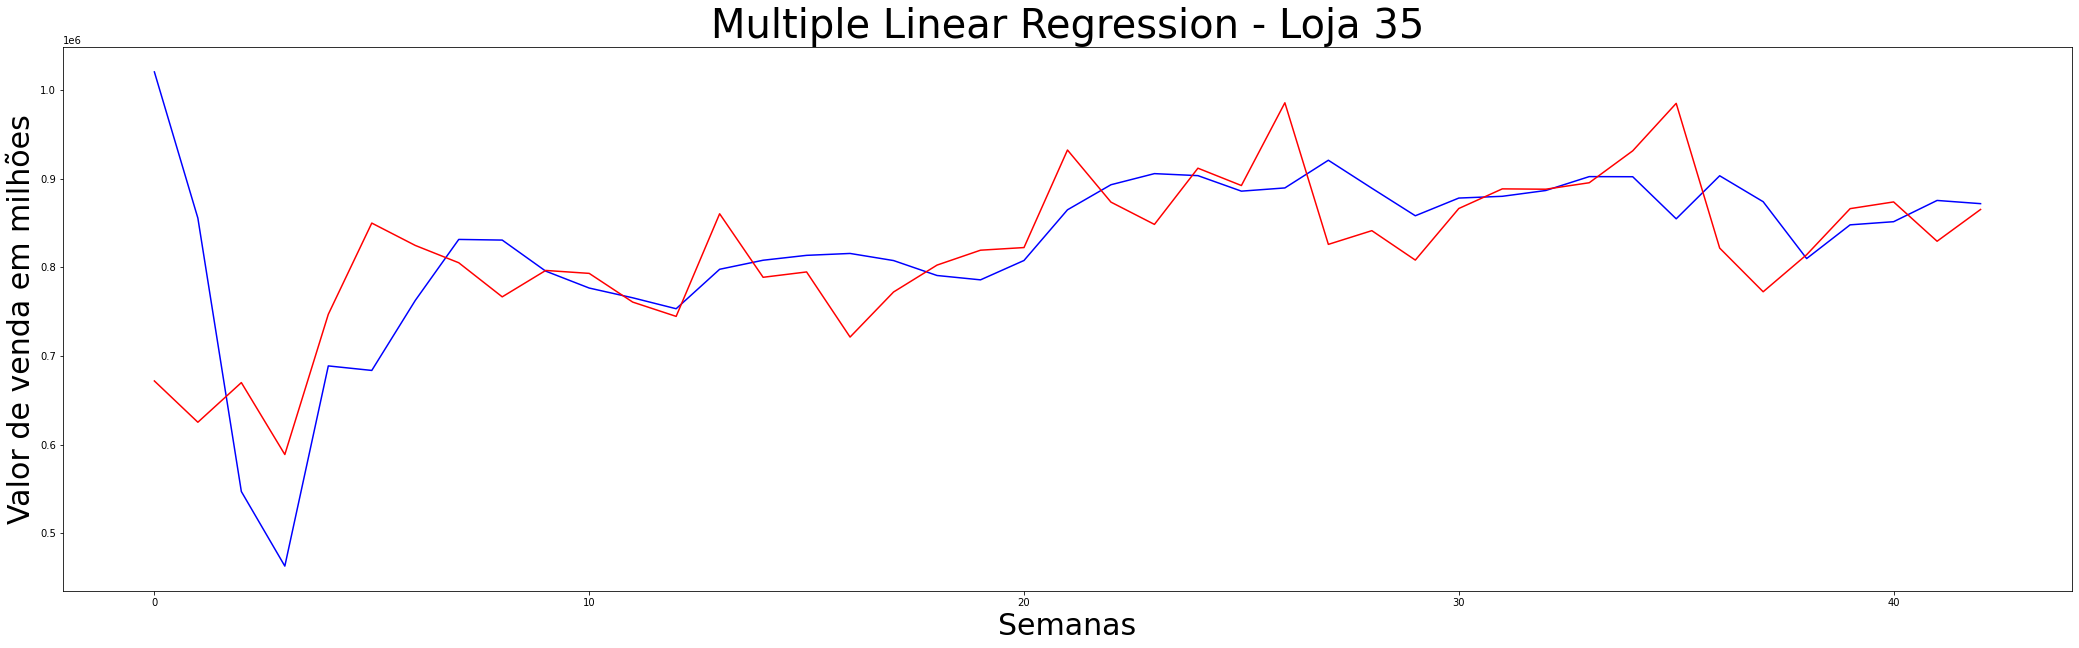

**************************************************
Resultados Loja 36:
-11.528956894381746 49475.36 65608.27


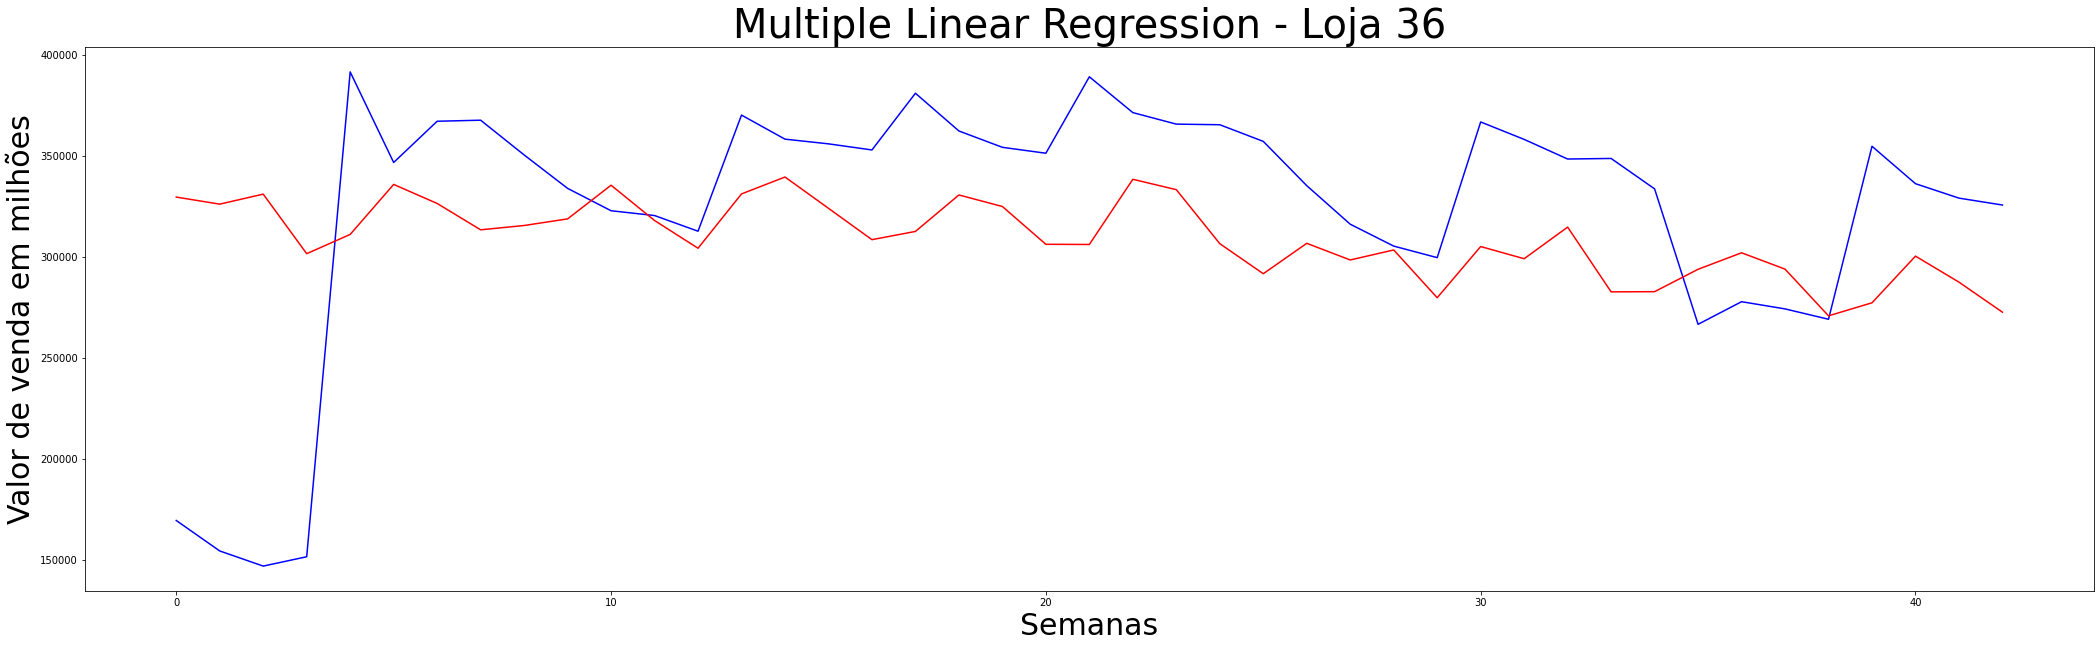

**************************************************
Resultados Loja 37:
-13.080983326343107 45894.754 65557.23


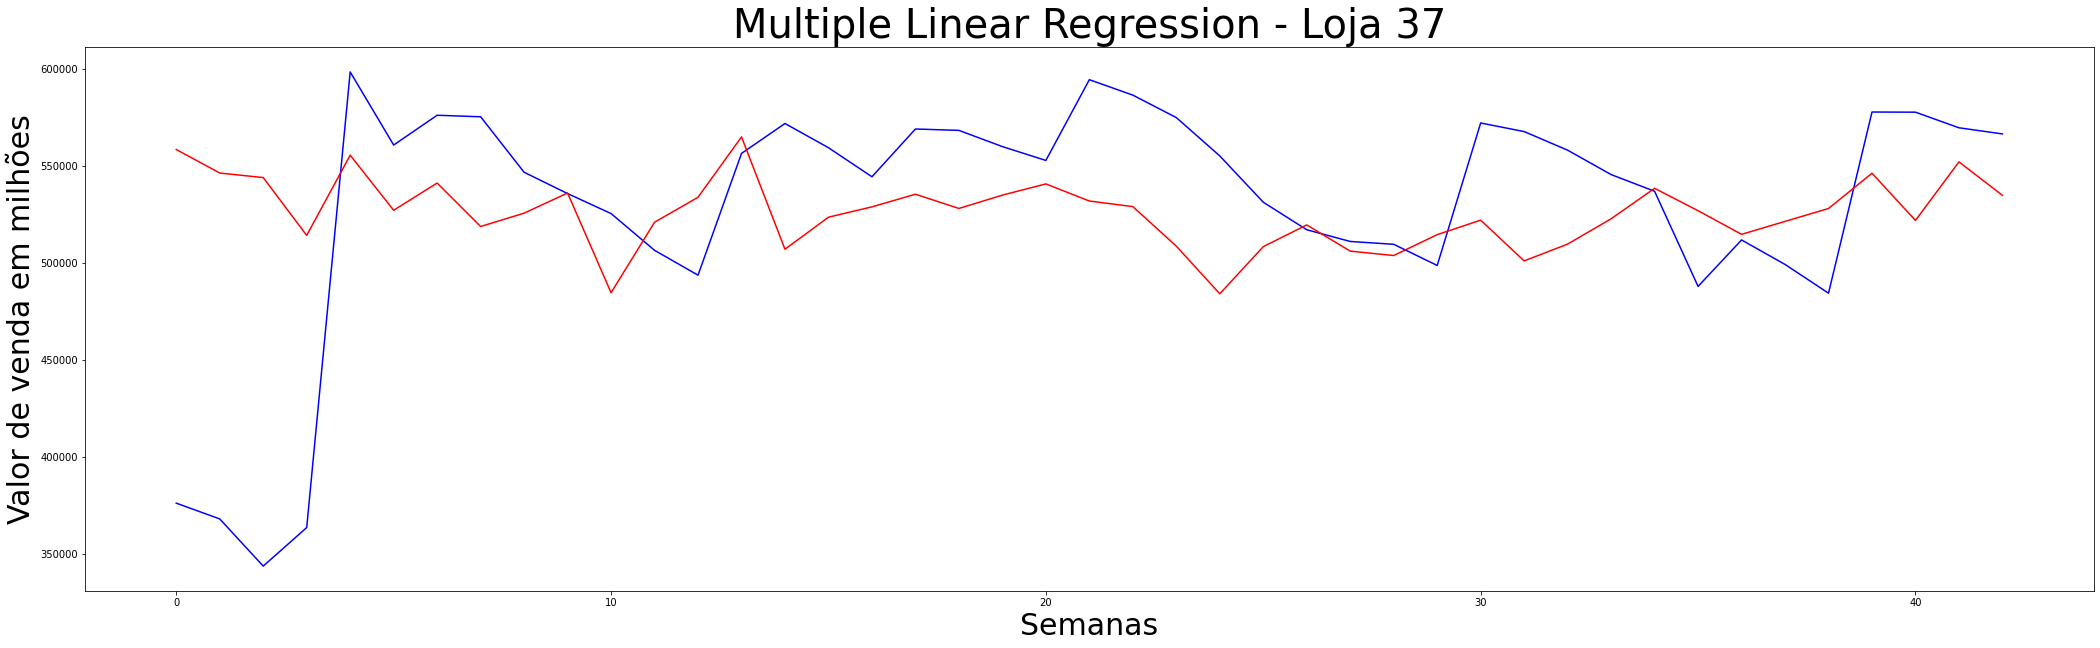

**************************************************
Resultados Loja 38:
-6.120739612808966 52947.484 72698.91


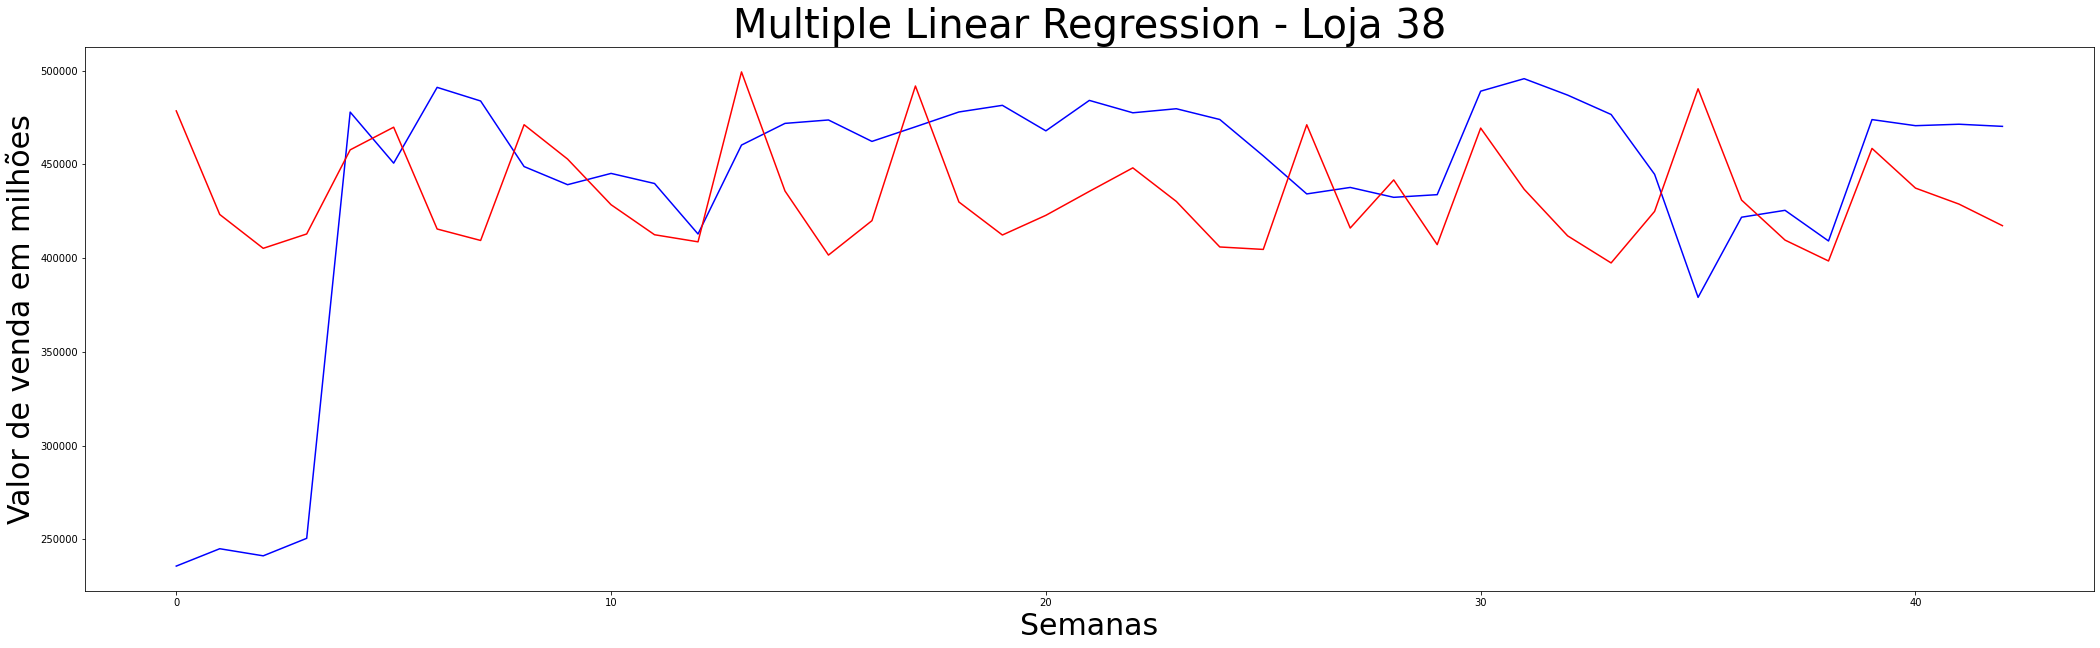

**************************************************
Resultados Loja 39:
-0.25636251121123177 83696.836 111146.56


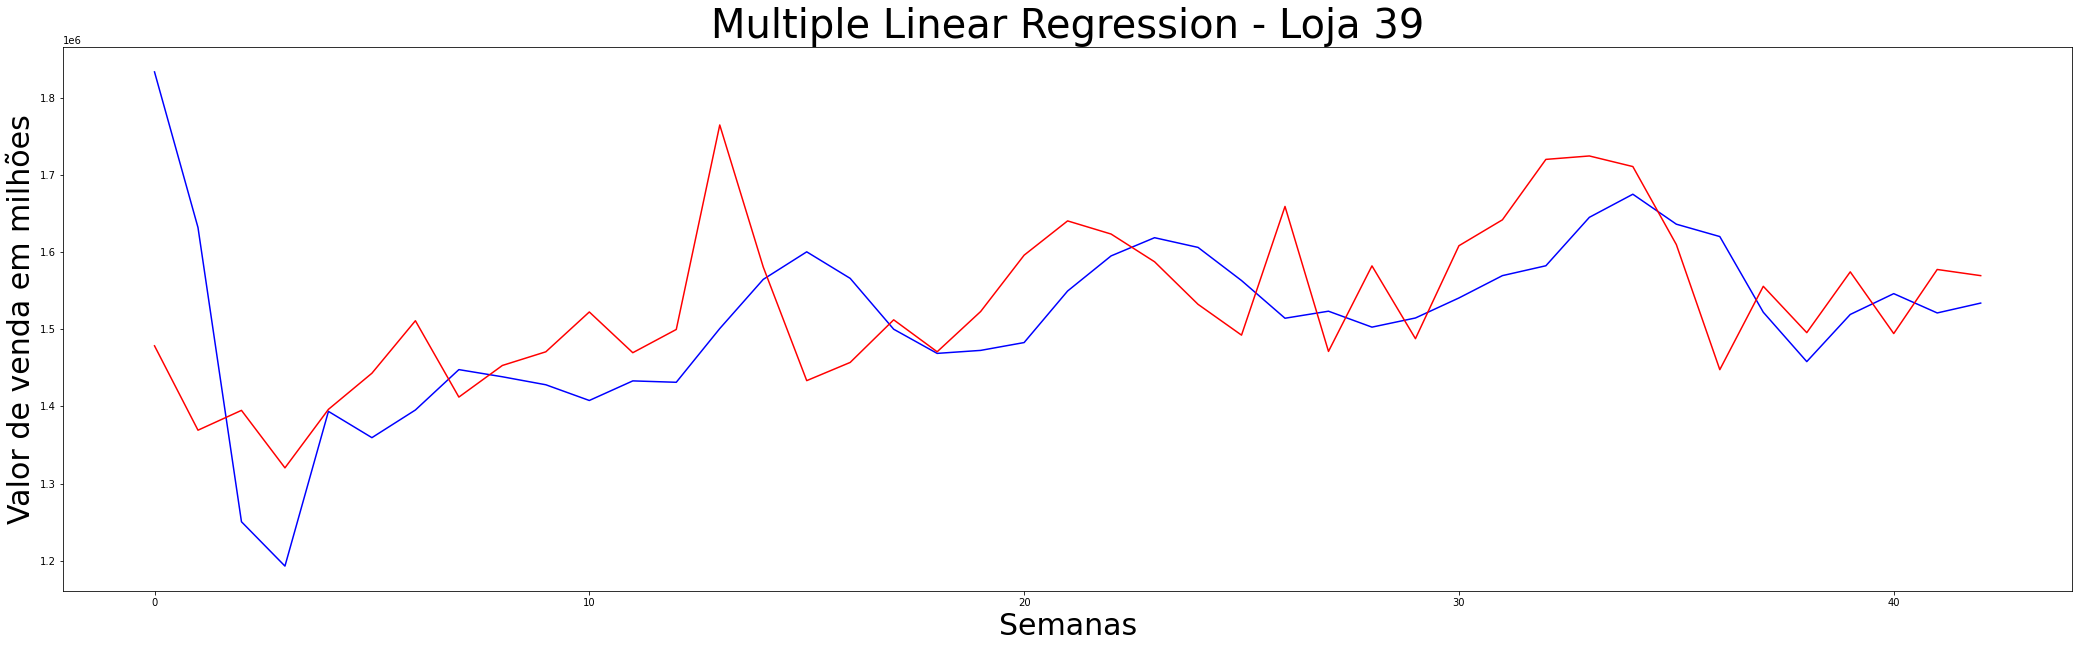

**************************************************
Resultados Loja 40:
-0.15757735883530755 75588.38 91509.72


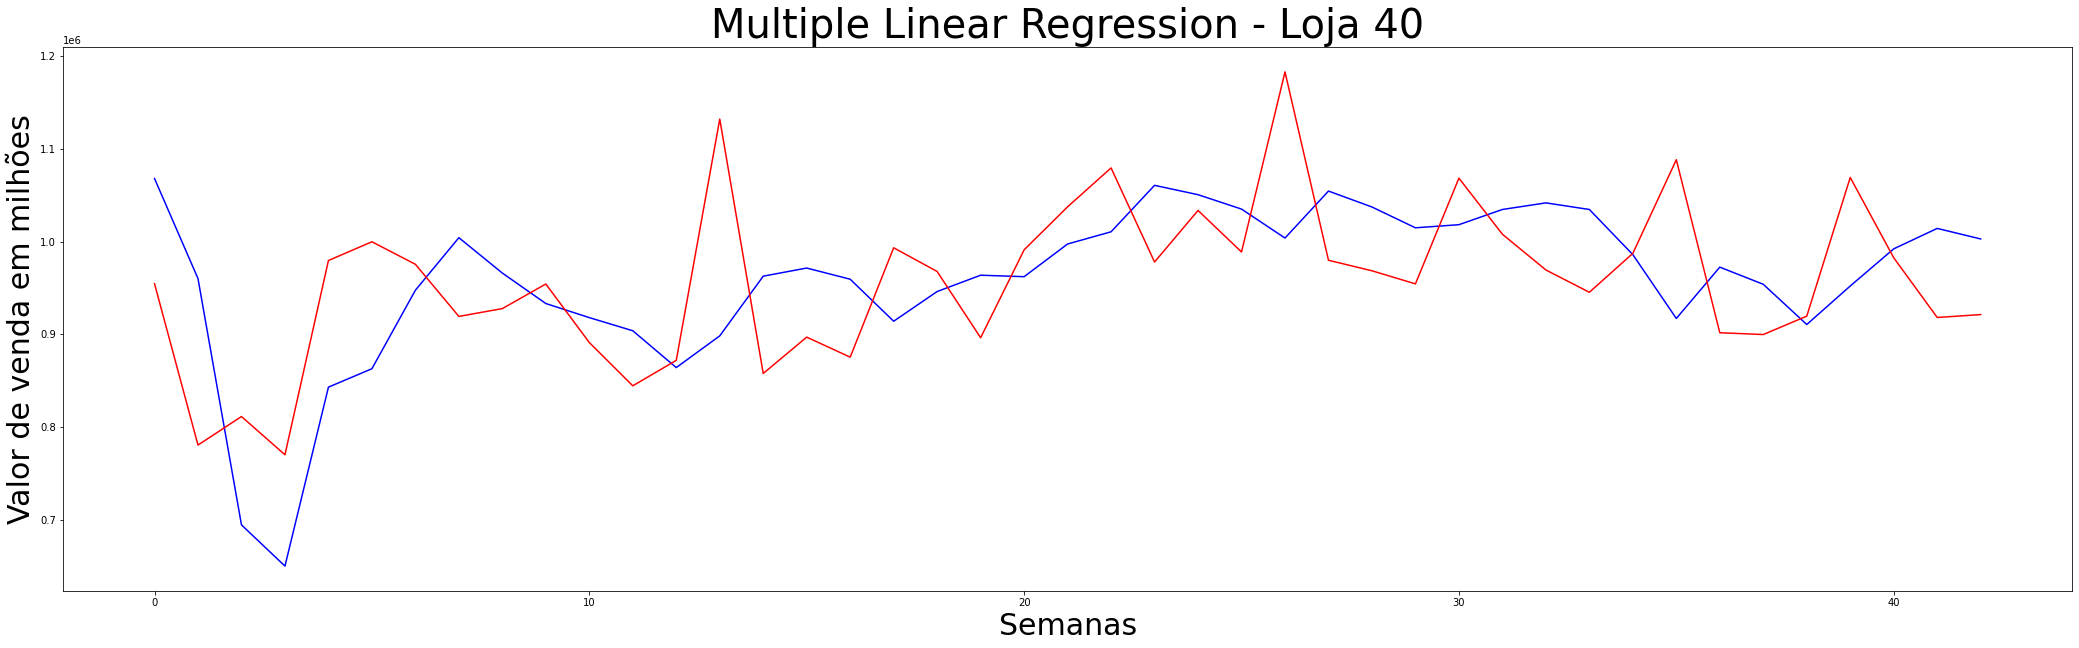

**************************************************
Resultados Loja 41:
0.08755444312296734 71868.33 99129.26


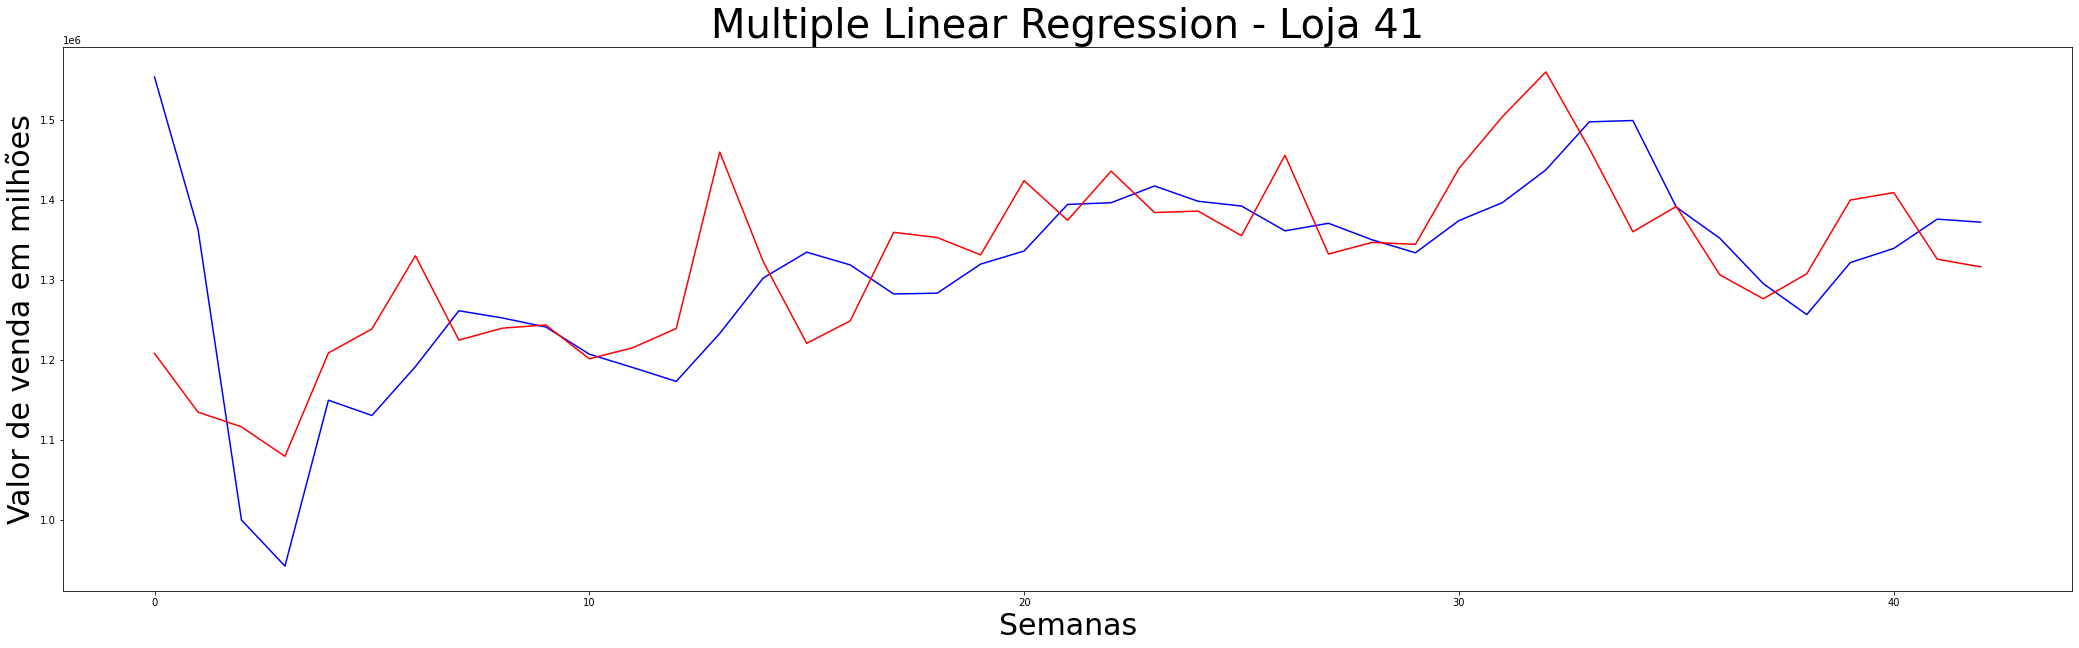

**************************************************
Resultados Loja 42:
-2.4190464132348968 70040.08 89358.58


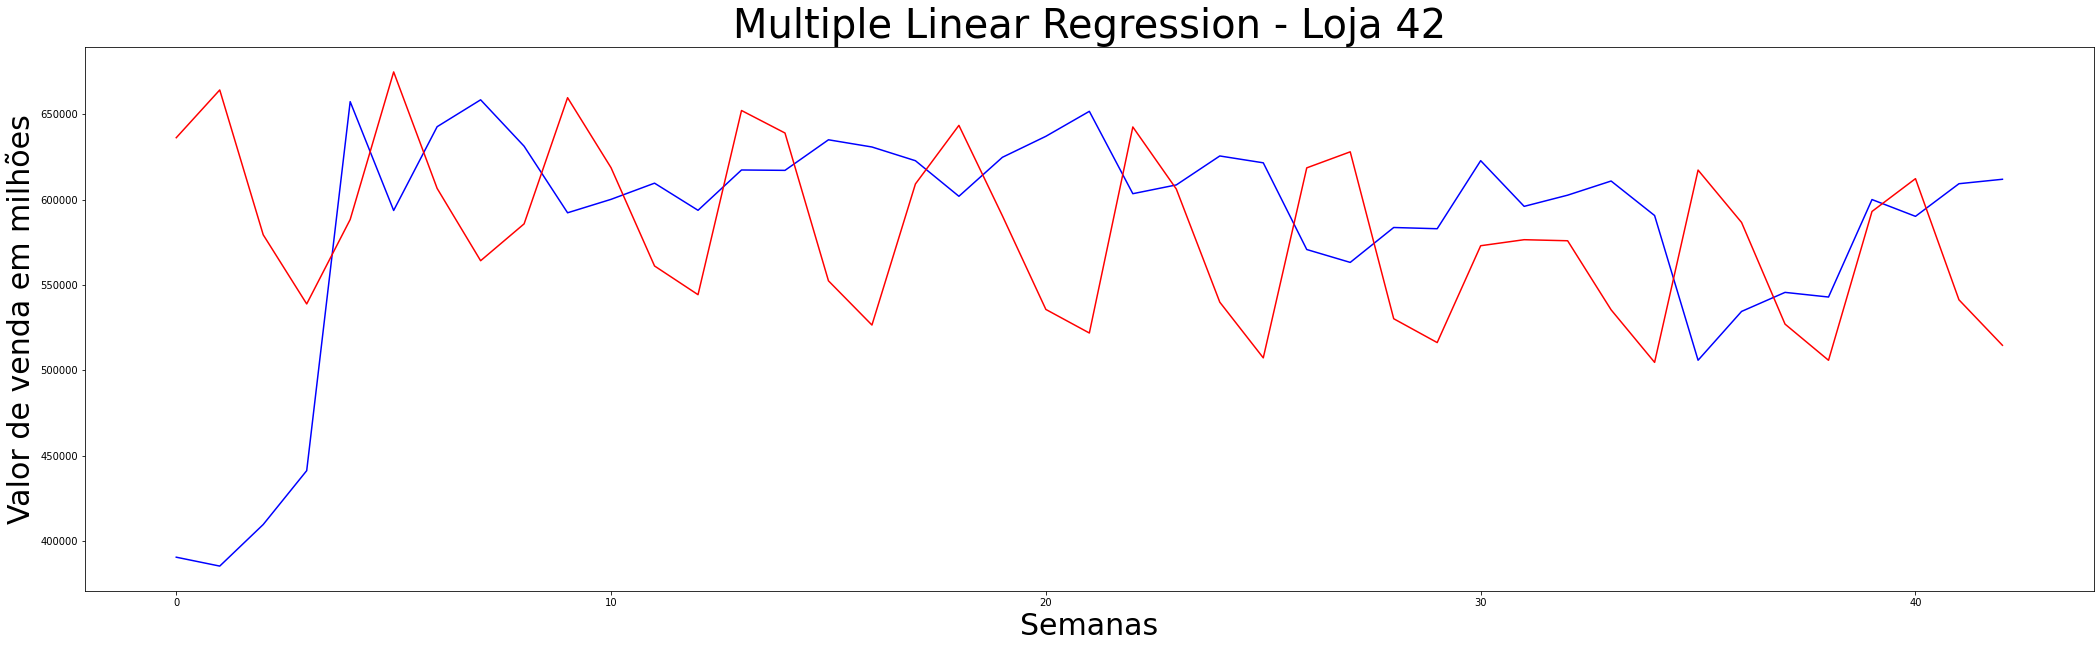

**************************************************
Resultados Loja 43:
-5.130652553112736 46166.668 69650.89


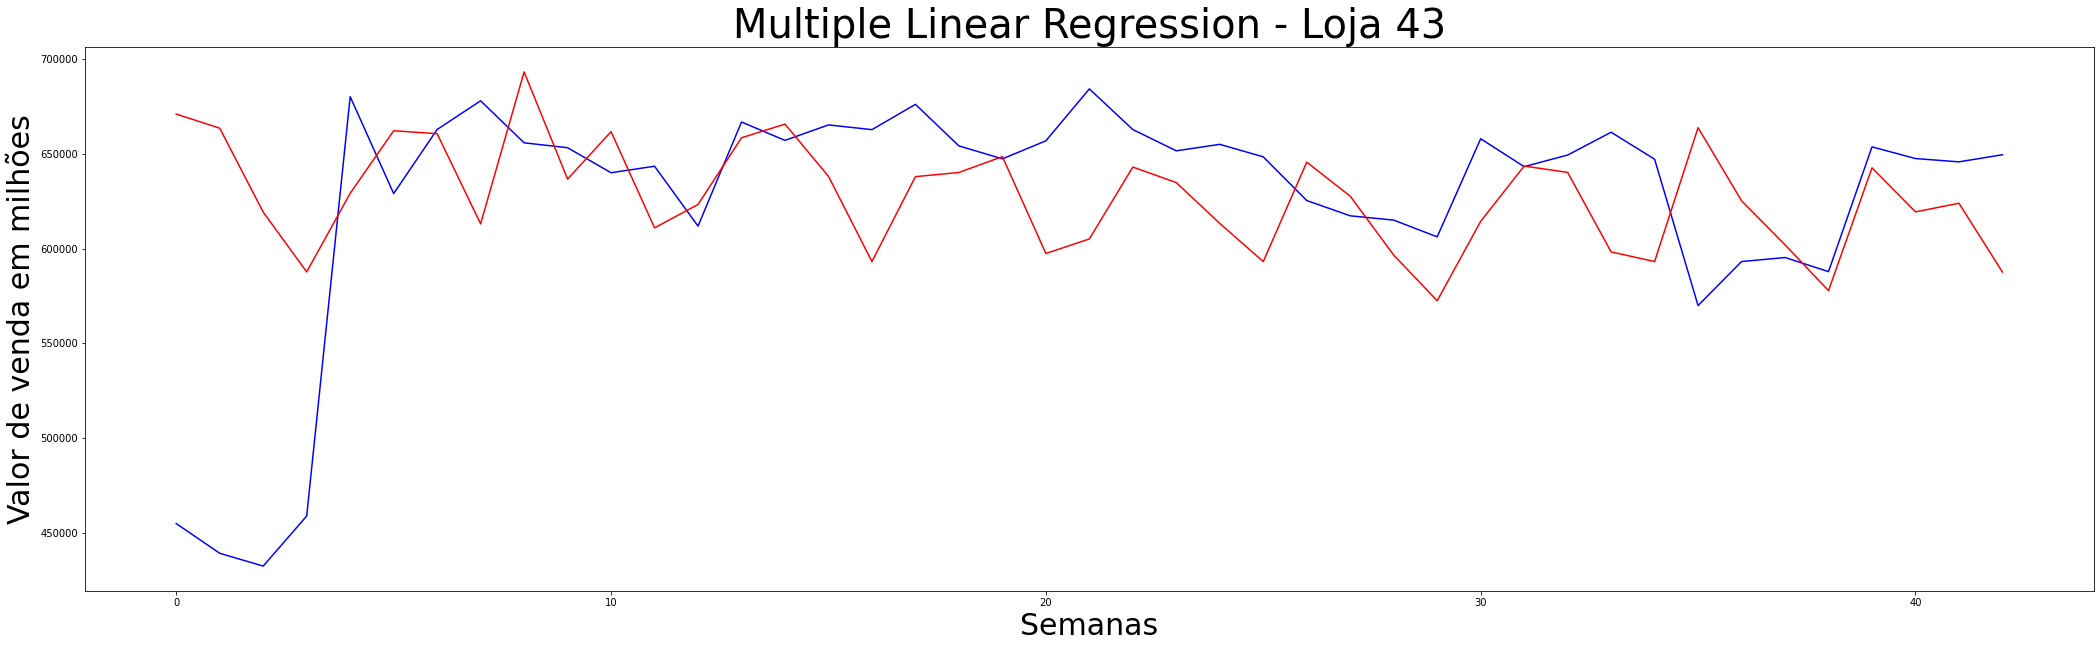

**************************************************
Resultados Loja 44:
-20.164447724753934 48581.055 64183.53


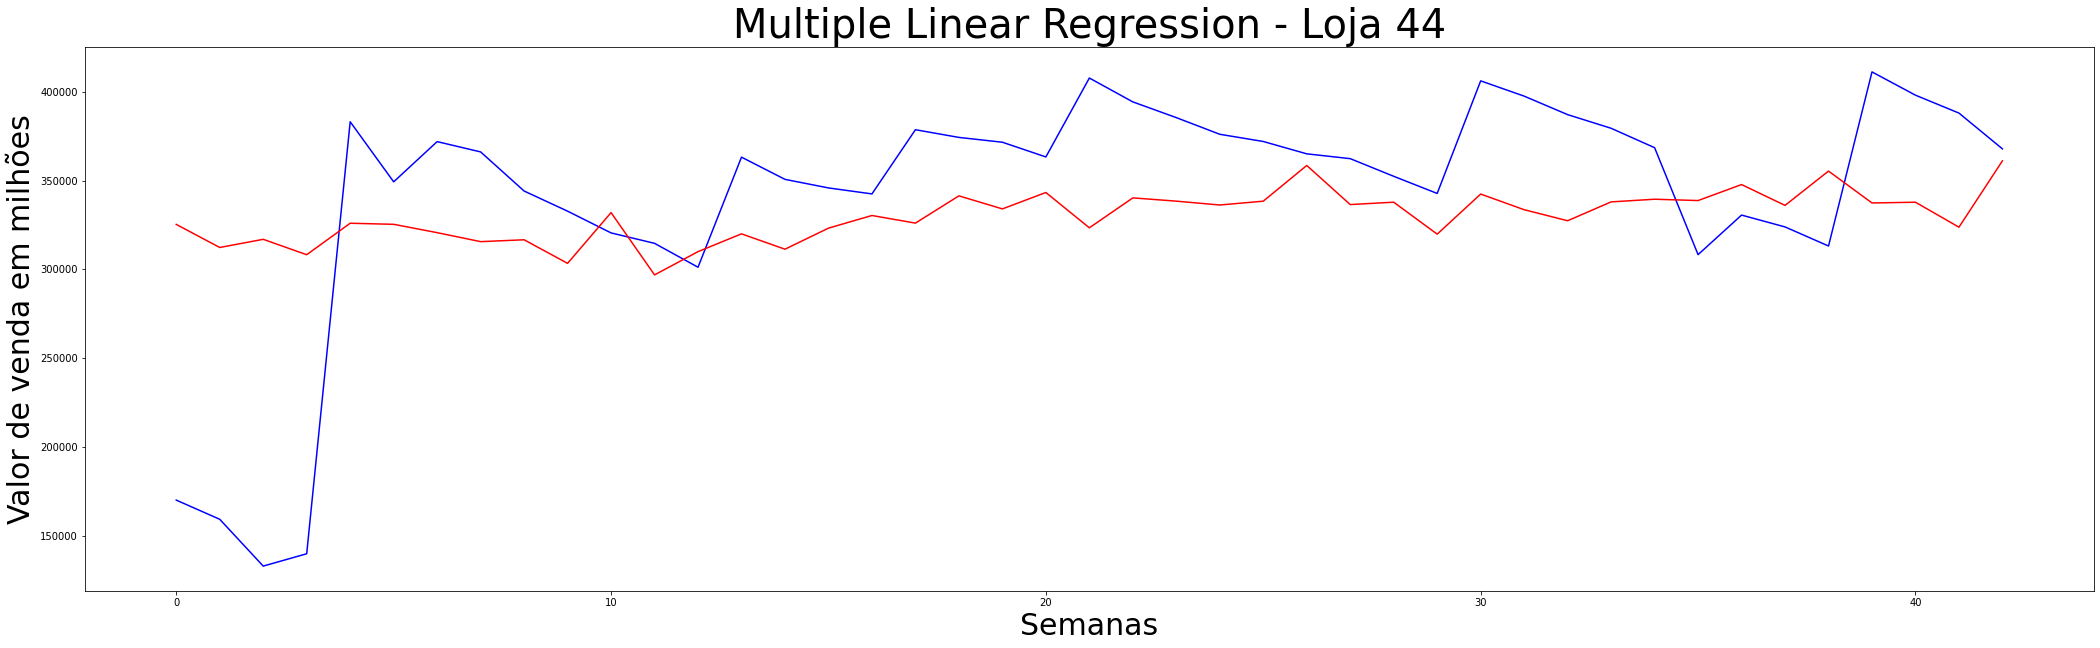

**************************************************
Resultados Loja 45:
-0.9719397005450676 52663.133 72487.27


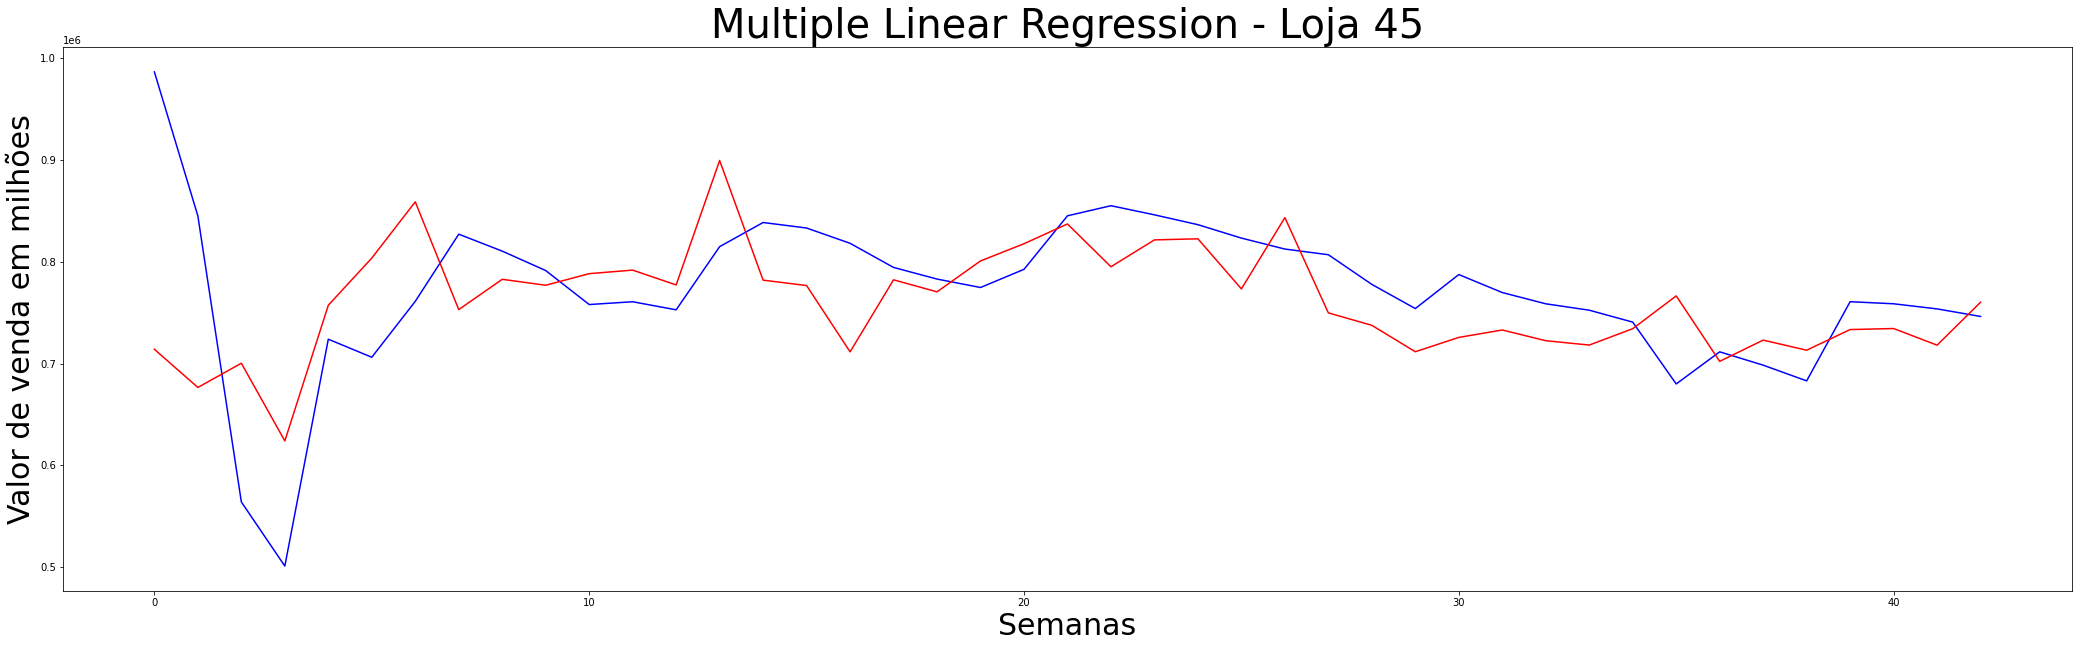

**************************************************


In [18]:
Xy_test = X_test
Xy_test["y"] = y_test

for i in range(1, 46):
  X_loja = Xy_test.where(Xy_test["Store_" + str(i)] == 1).dropna()
  y_loja = X_loja["y"]
  X_loja = X_loja.drop(["y"], axis=1)

  predictions_loja = mlr.predict(X_loja)

  print("Resultados Loja {}:".format(i))
  print(r2_score(y_loja, predictions_loja), mean_absolute_error(y_loja, predictions_loja), np.sqrt(mean_squared_error(y_loja, predictions_loja)))
  
  plt.figure(figsize = (36, 10)) 
  plt.plot(range(len(predictions_loja)), predictions_loja, 'b')
  plt.plot(range(len(predictions_loja)), y_loja, 'r')
  plt.title("Multiple Linear Regression - Loja {}".format(i), fontsize=40)
  plt.xlabel("Semanas", fontsize=30)
  plt.ylabel("Valor de venda em milhões", fontsize=30)

  plt.show()
  
  print(50*"*")
